In [1]:
library(DESeq2)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, table,
    tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loading r

In [2]:
library(tidyverse)

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::%within%() masks IRanges::%within%()
✖ dplyr::collapse()     masks IRanges::collapse()
✖ dplyr::combine()      masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::count()        masks matrixStats::count()
✖ dplyr::desc()         masks IRanges::desc()
✖ tidyr::expand()       masks S4Vectors::expand()
✖ dplyr::filter()       masks stats::filter()
✖ dplyr::first()        masks S4Vectors::first()
✖ dplyr::lag()          masks stats::lag()
✖ ggplot2::Position()   masks BiocGene

In [3]:
library(rtracklayer)

In [4]:
library(dplyr)

In [5]:
library(tximport)

In [6]:
library(org.Mm.eg.db)

Loading required package: AnnotationDbi


Attaching package: ‘AnnotationDbi’


The following object is masked from ‘package:dplyr’:

    select






In [7]:
library(ggpubr)

In [8]:
library(ggrepel)

In [9]:
library(ggplot2)

In [10]:
options(warn=-1)

In [11]:
gtf="/storage/wangzhen/bulkRNAseq/gencode.v47.annotation.gtf"
gtfinfo<-rtracklayer::import(gtf)
tx2gene <- gtfinfo%>%
  tibble::as_tibble() %>%
  dplyr::select(c(transcript_id,gene_id))%>%
  drop_na()%>%
  distinct()
colnames(tx2gene)<-c("TXNAME",'GENEID')

In [12]:
gene2symbol <- gtfinfo %>%
    tibble::as_tibble() %>%
    dplyr::filter(type=="gene")%>%
    dplyr::select(gene_id,gene_name)%>%
    distinct()|>
    as.data.frame()|>
    column_to_rownames("gene_id")

In [13]:
dir="/storage/wangzhen/salmon/"                                                        
files <- list.files(dir,pattern="quant.sf",recursive=T,full.names = T)
names(files) <- basename(dirname(files))

In [152]:
plotPCA<-function(df,meta,color="Condition",label="Sample"){
    df=df[,colnames(df)%in%rownames(meta)]
    p2<- prcomp(t(df))
    pca_data <- as.data.frame(predict(p2))
    pdata=cbind(pca_data[,c('PC1','PC2','PC3')],meta[rownames(pca_data),])
    pdata$Sample=rownames(pdata)
    fig<-ggscatter(pdata, x = "PC1", y = "PC2",color = color,size =3,
        palette = 'jco',ellipse = F, mean.point = F,star.plot = F,repel = TRUE,label=label,
        ggtheme = ggplot2::theme_minimal())
    fig
}


get_DEA_result<-function(dds,padj_threshold=0.05,logFC_threshold=0.5,use.pvalue=F){
    res <- results(dds)  
    df=as.data.frame(res)
    df$Contrast=resultsNames(dds)[length(resultsNames(dds))]
    df=gene2symbol%>%
        rownames_to_column()%>%
        dplyr::right_join(rownames_to_column(df),c("rowname"="rowname"))%>%
        arrange(padj,desc(abs(log2FoldChange)))
    if (use.pvalue==T){
        df$padj=df$pvalue
    }
    
    colnames(df)[1]="gene"
    df$bias="Not Changed"
    df$bias[df$padj < padj_threshold & df$log2FoldChange >  logFC_threshold] = "Up regulated"#str_split(df$Contrast[1],'_')[[1]][2]
    df$bias[df$padj < padj_threshold & df$log2FoldChange < -logFC_threshold] = "Down regulated"#str_split(df$Contrast[1],'_')[[1]][4]
    
    df$isDEG=ifelse(df$bias=='Not Changed',"Not Changed",'DEG')
    df%>%arrange(isDEG,desc(abs(log2FoldChange)))
}

plot_volcano<-function(result,padj_threshold=0.05,logFC_threshold=0.5){
    df=result%>%
        rownames_to_column("gene_id")%>%
        mutate(log10padj =-log10(result$padj))%>%
        mutate(FC_abs =abs(result$log2FoldChange))%>%
        arrange(desc(FC_abs))%>% 
        drop_na()
    df2=df[df$isDEG=="DEG",]
    if ("gene_symbol" %in% colnames(df)){
        label="gene_symbol"
        showgene=df2$gene_symbol[1:20]
    }else if ("gene_name" %in% colnames(df)){
        label="gene_name"
        showgene=df2$gene_name[1:20]
    }else{
        label=NULL
        showgene=NULL
    }
    
    process_string <- function(x) {
    parts <- unlist(strsplit(x, "_"))
    return(paste(parts[2], parts[4],sep='_vs_'))
    }

    title=process_string(df$Contrast[1])
    yintercept=log10(padj_threshold)*-1
    xintercept=logFC_threshold
    
     if ("Down regulated" %in% df$bias){
        cols=c("#1F77B4FF","#999999","#D62728FF")
    }else{
    
        cols=c("#999999","#D62728FF")
    }
    
    yMax=max(df$log10padj)+5    
    if (yMax>100){
        yMax=100    
    }
    
    xMax=max(abs(df$log2FoldChange))+1
    
    
    df$bias=ifelse(df$bias=="Not Changed",'Not-significant',df$bias)
    df$bias=ifelse(df$bias=="Down regulated",'Down-regulated',df$bias)
    df$bias=ifelse(df$bias=="Up regulated",'Up-regulated',df$bias)
    df$bias=factor(df$bias,levels=c("Up-regulated",'Not-significant','Down-regulated'))
    
    counts <- table(df$bias)
    count_vec <- as.character(counts[as.character(df$bias)])
    df$bias <- paste0(df$bias, " (", count_vec, ")")
    
    
    fig<-ggscatter(df, 
              x = "log2FoldChange", 
              y = "log10padj", 
              ylim=c(0,yMax), xlim=c(-xMax,xMax),
              ylab = "-log10(padj)",
              title = title,
              color = "bias",
              size = 3,
              label = label, 
              repel = T,
              show.legend.text = F,
              palette =cols ,
              label.select = showgene)+
              geom_hline(yintercept=yintercept,col='grey',linetype=5)+
              geom_vline(xintercept=c(xintercept*-1,xintercept),col='grey',linetype=5)+theme_bw()
    
    fig + theme(
    legend.title = element_blank(),
    legend.text = element_text(size=13),#legend.key.size = unit(0.5, 'cm'),
    legend.position = c(.32, .99),
    legend.justification = c("right", "top"),
    legend.box.just = "right",
    legend.margin = margin(5, 5, 5, 5),
    plot.title = element_text(hjust = 0.5,size=20),
    axis.text.x=element_text(size=15,face="plain"),axis.text.y=element_text(size=15,face="plain"),
    axis.title.x=element_text(size=20,face="plain"),axis.title.y=element_text(size=20,face="plain"),
    )

    
}


In [15]:
meta=DataFrame(Sample=names(files))
meta$Group1=sapply(str_split(meta$Sample,'-'),'[',1)
meta$Group2=sapply(str_split(meta$Sample,'-'),'[',2)
meta$Group3=paste(meta$Group1,meta$Group2,sep='-')

meta=as.data.frame(meta)|>column_to_rownames("Sample")
meta

,Group1,Group2,Group3
,<chr>,<chr>,<chr>
A12-1,A12,1,A12-1
A12-2,A12,2,A12-2
A12-3,A12,3,A12-3
A12-4,A12,4,A12-4
A12-5,A12,5,A12-5
A12-6,A12,6,A12-6
A24-1,A24,1,A24-1
A24-2,A24,2,A24-2
A24-3,A24,3,A24-3


In [16]:
txi <- suppressMessages(tximport(files, type="salmon",tx2gene = tx2gene))

In [17]:
outdir="/storage/wangzhen/results0115/"

In [18]:
TPM=txi$abundance
TPM=cbind(gene2symbol[rownames(TPM),,drop=F],TPM)
write.csv(TPM,paste0(outdir,'/TPM.csv'))

In [19]:
salmon_deseq<-function(files,coldata,ref="D"){
    subfiles=files[rownames(coldata)]
    capture.output(
        subtxi <- suppressMessages(tximport(subfiles, type="salmon",tx2gene = tx2gene,ignoreAfterBar=T)),
        dds <- suppressMessages(DESeqDataSetFromTximport(subtxi,
                                           colData = coldata,
                                           design = ~ Group))
        )

    dds$Group <- relevel(dds$Group, ref = ref)
    keep <- rowSums(counts(dds)) >= 10
    dds <- dds[keep,]
    dds <- DESeq(dds,quiet=T)
    dds

}

### A4-1/2_vs_A4-3/4

In [26]:
Contrast="A4 12_vs_A4 34"

coldata=meta|>filter(Group1%in%c("A4")&Group2%in% c("1", "2", "3", "4"))
coldata$Group <- ifelse(coldata$Group2 %in% c("1", "2"), "A4 12", "A4 34")
coldata

,Group1,Group2,Group3,Group
,<chr>,<chr>,<chr>,<chr>
A4-1,A4,1,A4-1,A4 12
A4-2,A4,2,A4-2,A4 12
A4-3,A4,3,A4-3,A4 34
A4-4,A4,4,A4-4,A4 34


In [27]:
dds=salmon_deseq(files,coldata,'A4 12')
norm=as.data.frame(counts(dds, normalized=T))
res=get_DEA_result(dds,padj_threshold=0.05,logFC_threshold=0.5)
table(res$bias)

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]




Down regulated    Not Changed   Up regulated 
             4          19867              2 

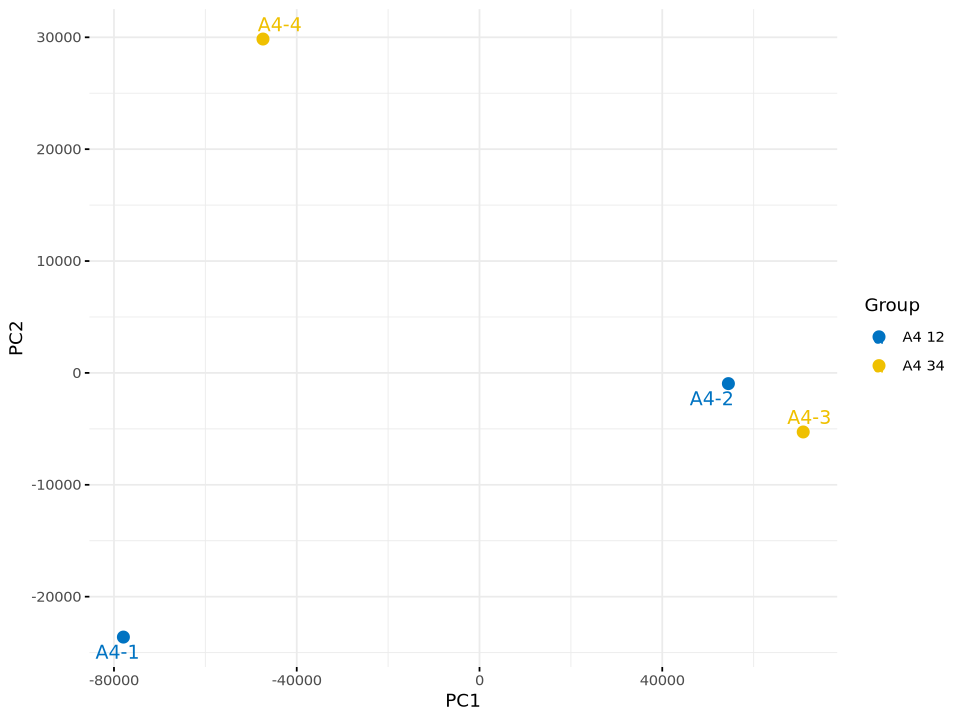

In [28]:
options(repr.plot.width=8, repr.plot.height=6)  
pca_fig=plotPCA(norm,coldata,color="Group")
pca_fig

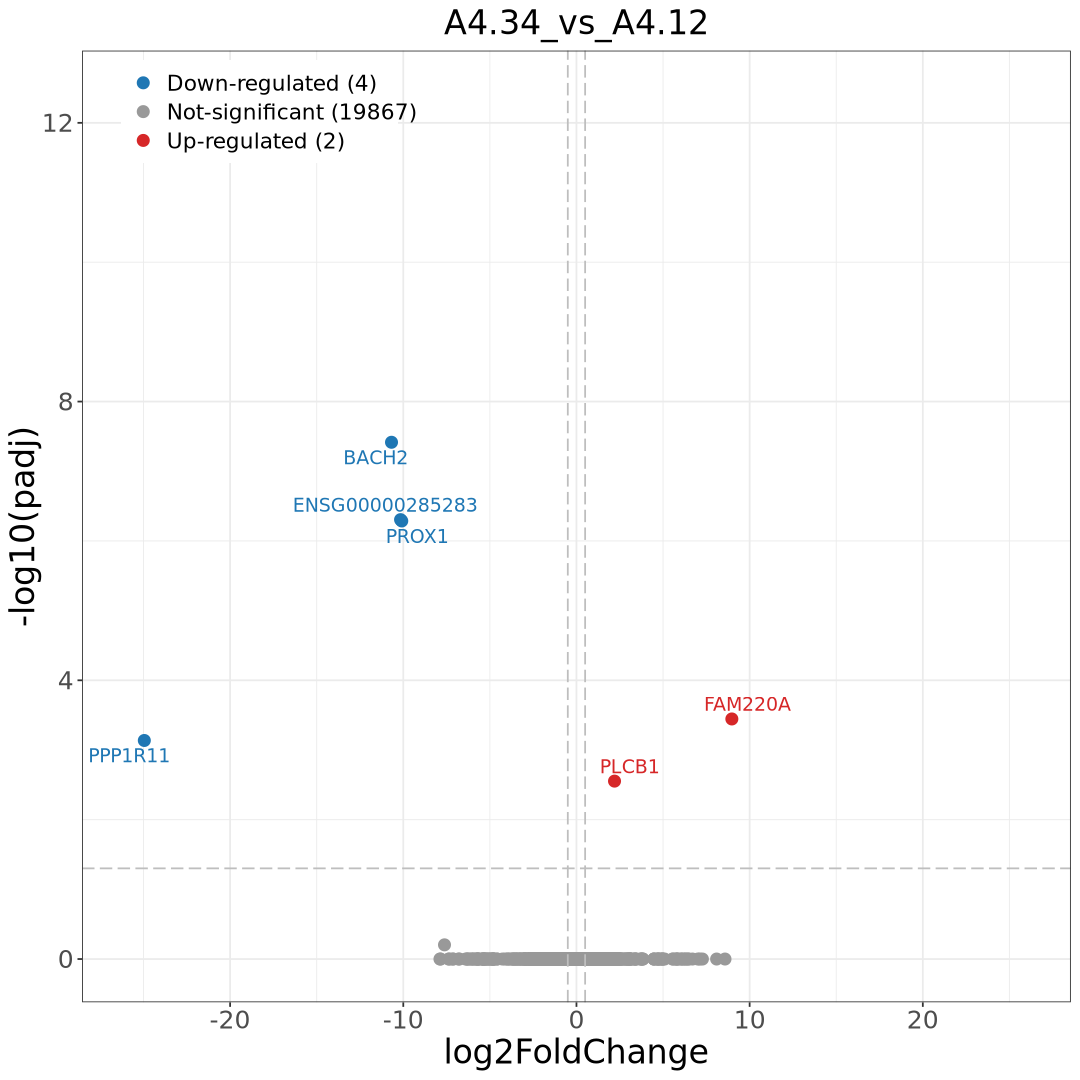

In [29]:
options(repr.plot.width=9, repr.plot.height=9)  

volcano_fig=plot_volcano(res,padj_threshold=0.05,logFC_threshold=0.5)
volcano_fig

In [30]:
get_outname <- function(outdir, Contrast, extension) {
  return(file.path(outdir, paste0(Contrast, "_", extension)))
}

In [31]:
filename=get_outname(outdir,Contrast,"DESeq2.csv")
write.csv(res,filename,quote=F)

filename=get_outname(outdir,Contrast,"pca.pdf")
ggsave(filename,pca_fig,width = 6, height = 6)

filename=get_outname(outdir,Contrast,"volcano.pdf")
ggsave(filename,volcano_fig,width = 8, height = 8)

### A12-1/2_vs_A12-3/4

In [20]:
Contrast="A12 12_vs_A12 34"

coldata=meta|>filter(Group1%in%c("A12")&Group2%in% c("1", "2", "3", "4"))
coldata$Group <- ifelse(coldata$Group2 %in% c("1", "2"), "A12 12", "A12 34")
coldata

,Group1,Group2,Group3,Group
,<chr>,<chr>,<chr>,<chr>
A12-1,A12,1,A12-1,A12 12
A12-2,A12,2,A12-2,A12 12
A12-3,A12,3,A12-3,A12 34
A12-4,A12,4,A12-4,A12 34


In [21]:
dds=salmon_deseq(files,coldata,'A12 12')
norm=as.data.frame(counts(dds, normalized=T))
res=get_DEA_result(dds,padj_threshold=0.05,logFC_threshold=0.5)
table(res$bias)

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]




Down regulated    Not Changed   Up regulated 
             5          20088              6 

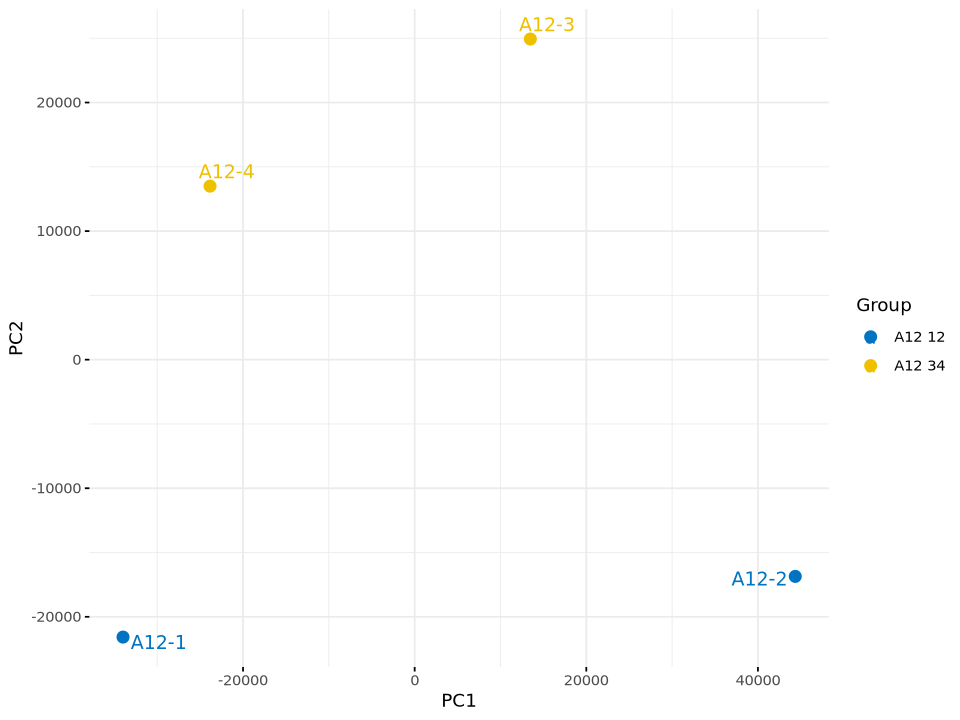

In [22]:
options(repr.plot.width=8, repr.plot.height=6)  
pca_fig=plotPCA(norm,coldata,color="Group")
pca_fig

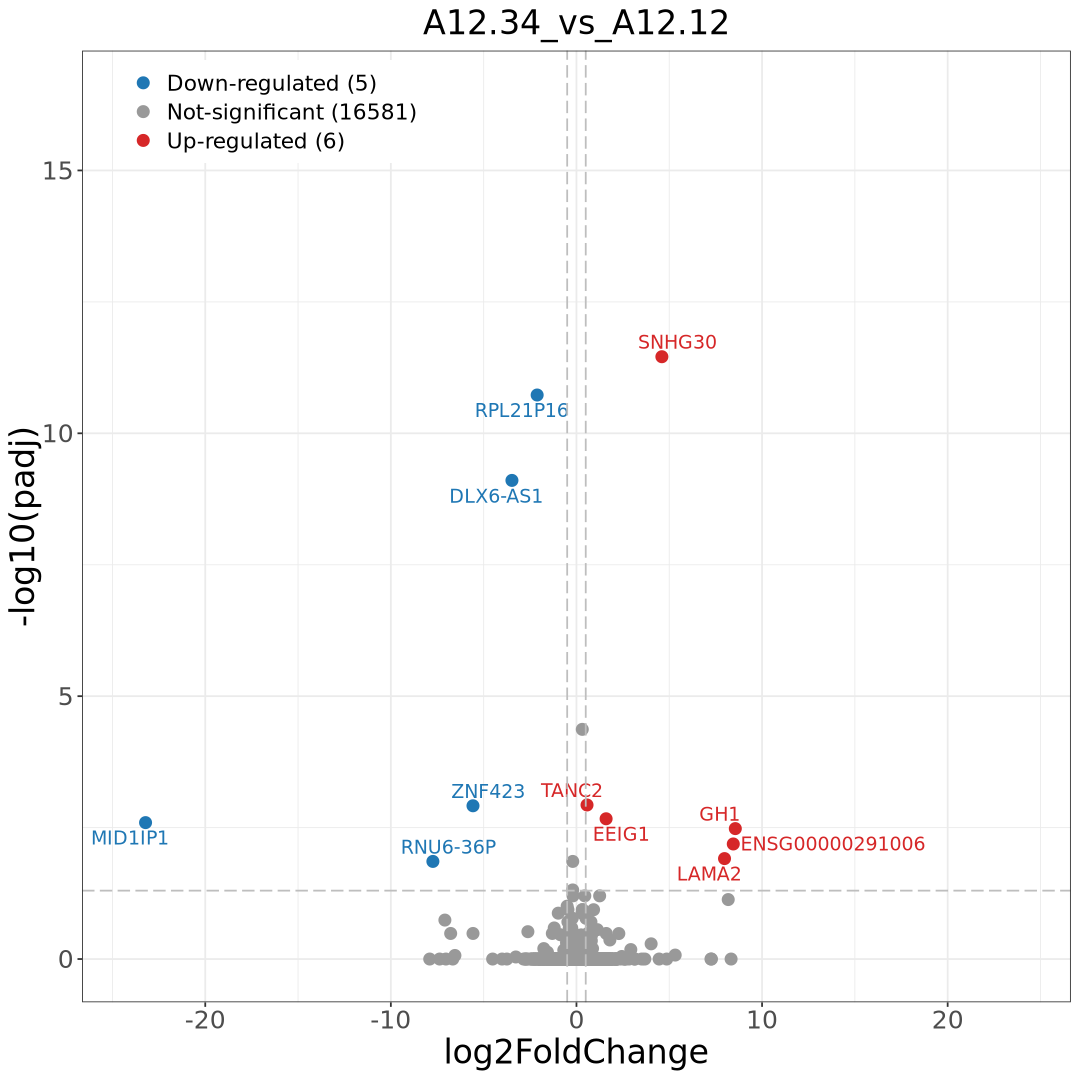

In [23]:
options(repr.plot.width=9, repr.plot.height=9)  

volcano_fig=plot_volcano(res,padj_threshold=0.05,logFC_threshold=0.5)
volcano_fig

In [24]:
get_outname <- function(outdir, Contrast, extension) {
  return(file.path(outdir, paste0(Contrast, "_", extension)))
}

In [25]:
filename=get_outname(outdir,Contrast,"DESeq2.csv")
write.csv(res,filename,quote=F)

filename=get_outname(outdir,Contrast,"pca.pdf")
ggsave(filename,pca_fig,width = 6, height = 6)

filename=get_outname(outdir,Contrast,"volcano.pdf")
ggsave(filename,volcano_fig,width = 8, height = 8)

### A24-1/2_vs_A24-3/4

In [121]:
Contrast="A24 12_vs_A24 34"

coldata=meta|>filter(Group1%in%c("A24")&Group2%in% c("1", "2", "3", "4"))
coldata$Group <- ifelse(coldata$Group2 %in% c("1", "2"), "A24 12", "A24 34")
coldata

,Group1,Group2,Group3,Group
,<chr>,<chr>,<chr>,<chr>
A24-1,A24,1,A24-1,A24 12
A24-2,A24,2,A24-2,A24 12
A24-3,A24,3,A24-3,A24 34
A24-4,A24,4,A24-4,A24 34


In [122]:
dds=salmon_deseq(files,coldata,'A24 12')
norm=as.data.frame(counts(dds, normalized=T))
res=get_DEA_result(dds,padj_threshold=0.05,logFC_threshold=0.5)
table(res$bias)

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]




Down regulated    Not Changed   Up regulated 
           153          18628           1348 

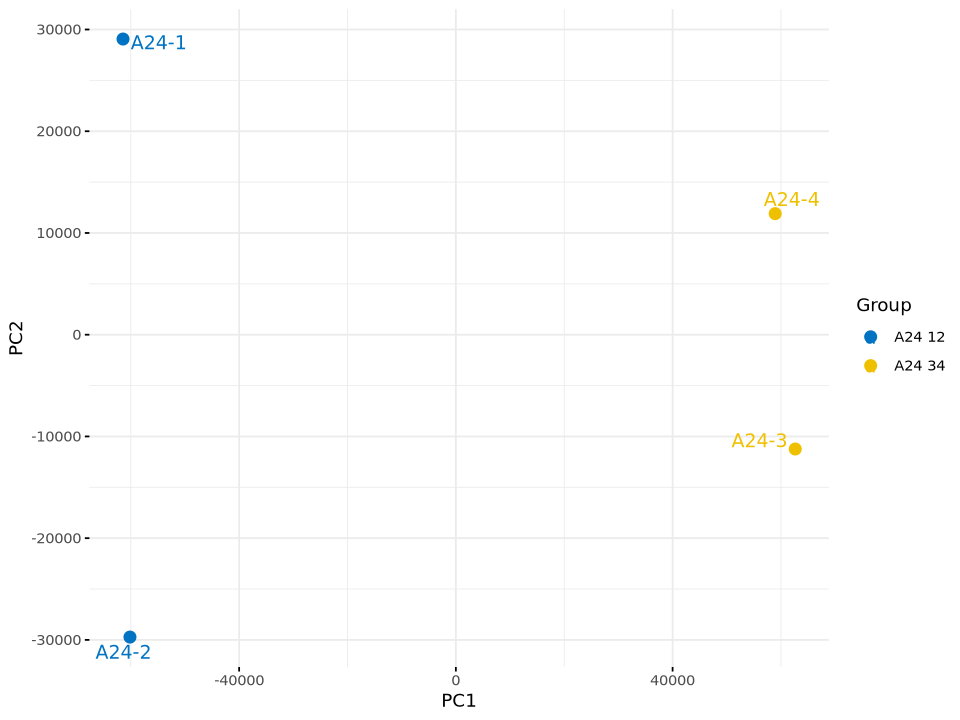

In [123]:
options(repr.plot.width=8, repr.plot.height=6)  
pca_fig=plotPCA(norm,coldata,color="Group")
pca_fig

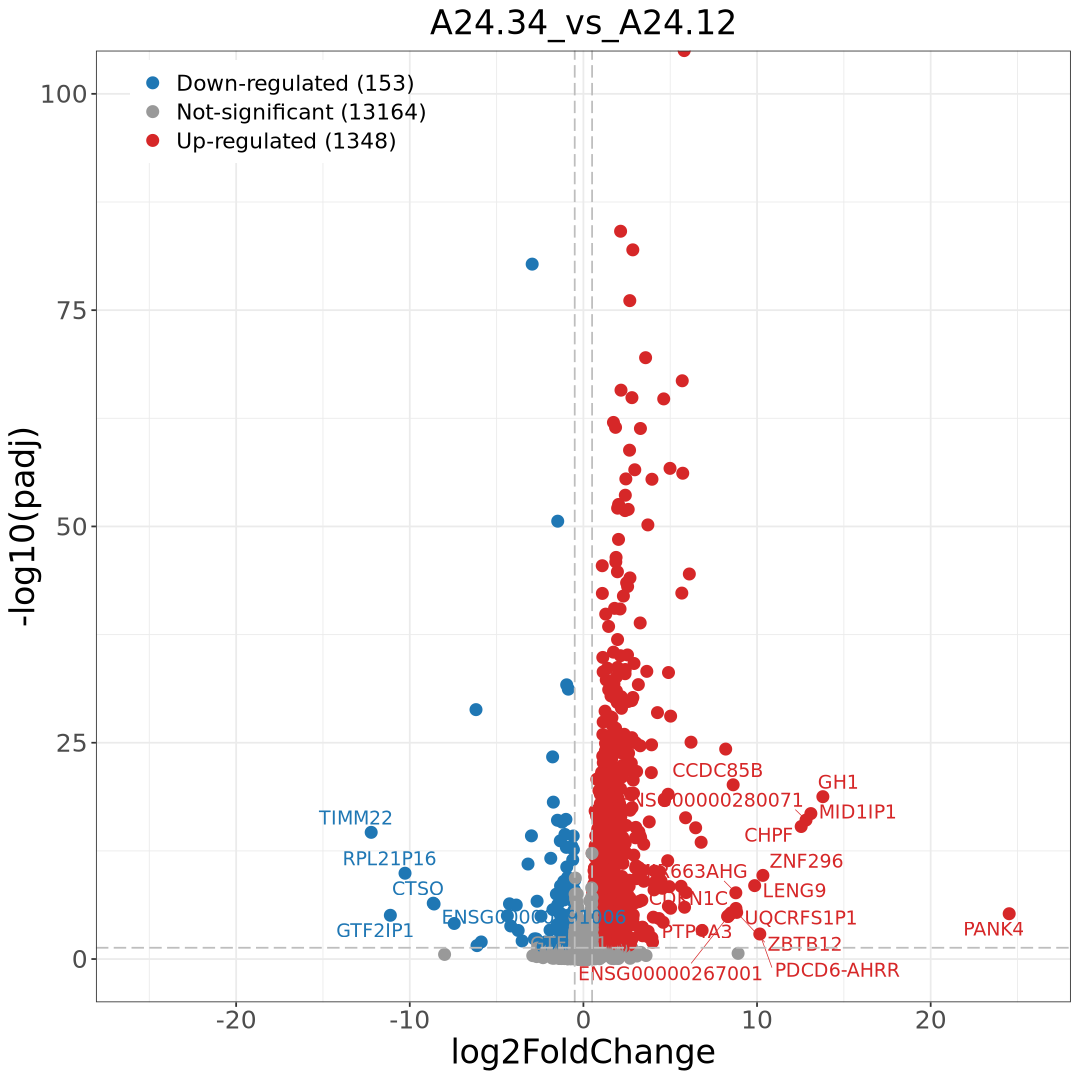

In [137]:
options(repr.plot.width=9, repr.plot.height=9)  

volcano_fig=plot_volcano(res,padj_threshold=0.05,logFC_threshold=0.5)
volcano_fig

In [138]:
get_outname <- function(outdir, Contrast, extension) {
  return(file.path(outdir, paste0(Contrast, "_", extension)))
}

In [139]:
filename=get_outname(outdir,Contrast,"DESeq2.csv")
write.csv(res,filename,quote=F)

filename=get_outname(outdir,Contrast,"pca.pdf")
ggsave(filename,pca_fig,width = 6, height = 6)

filename=get_outname(outdir,Contrast,"volcano.pdf")
ggsave(filename,volcano_fig,width = 8, height = 8)

### A4-1/2_vs_A4-5/6

In [38]:
Contrast="A4 12_vs_A4 56"

coldata=meta|>filter(Group1%in%c("A4")&Group2%in% c("1", "2", "5", "6"))
coldata$Group <- ifelse(coldata$Group2 %in% c("1", "2"), "A4 12", "A4 56")
coldata

,Group1,Group2,Group3,Group
,<chr>,<chr>,<chr>,<chr>
A4-1,A4,1,A4-1,A4 12
A4-2,A4,2,A4-2,A4 12
A4-5,A4,5,A4-5,A4 56
A4-6,A4,6,A4-6,A4 56


In [39]:
dds=salmon_deseq(files,coldata,'A4 12')
norm=as.data.frame(counts(dds, normalized=T))
res=get_DEA_result(dds,padj_threshold=0.05,logFC_threshold=0.5)
table(res$bias)

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]




Down regulated    Not Changed   Up regulated 
             4          19944              2 

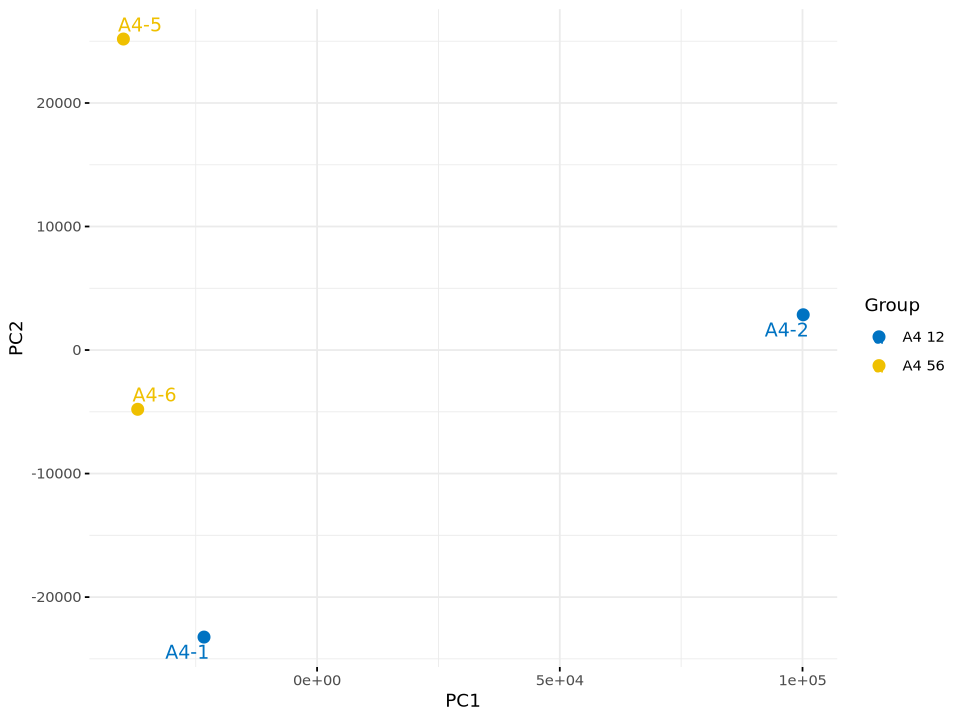

In [40]:
options(repr.plot.width=8, repr.plot.height=6)  
pca_fig=plotPCA(norm,coldata,color="Group")
pca_fig

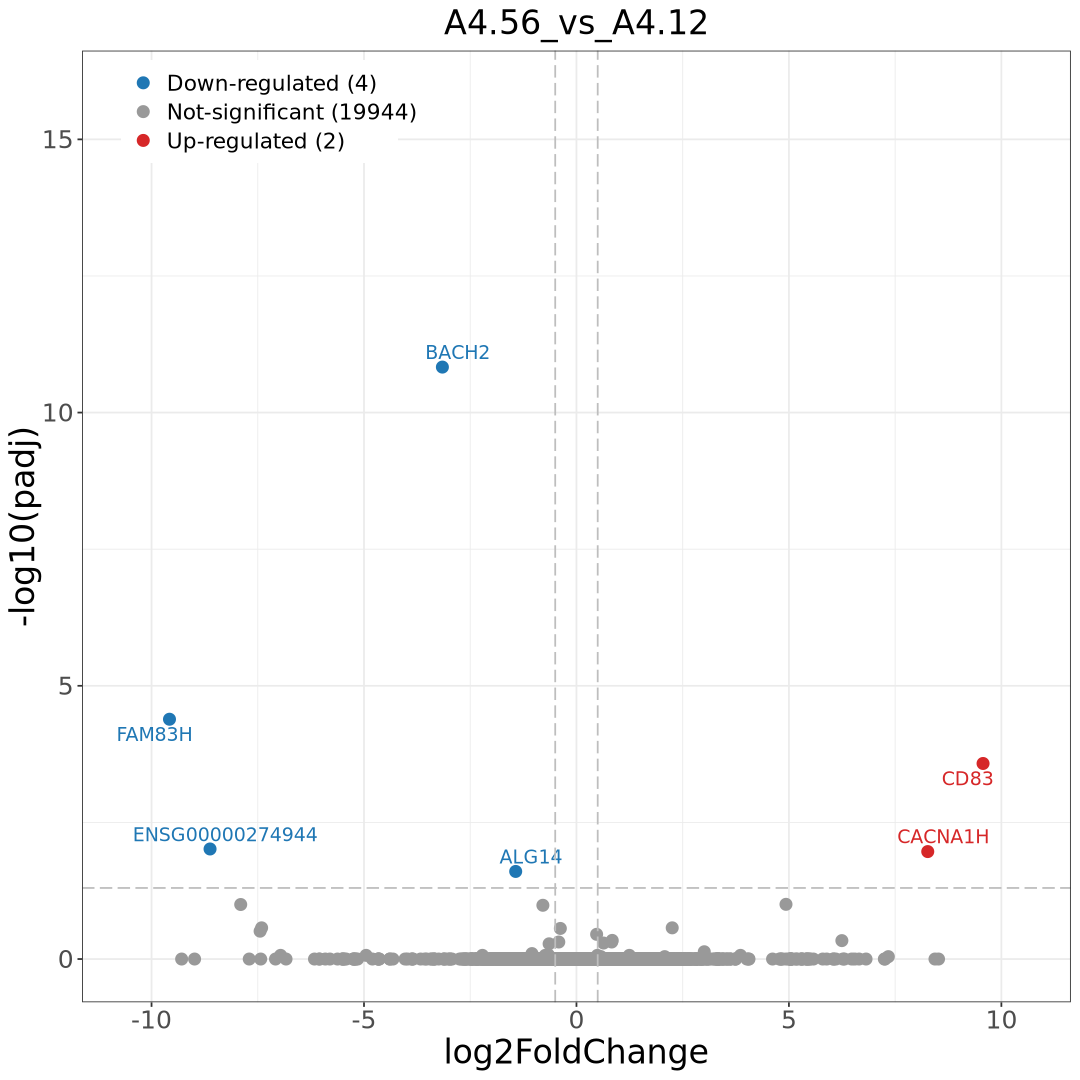

In [41]:
options(repr.plot.width=9, repr.plot.height=9)  

volcano_fig=plot_volcano(res,padj_threshold=0.05,logFC_threshold=0.5)
volcano_fig

In [42]:
get_outname <- function(outdir, Contrast, extension) {
  return(file.path(outdir, paste0(Contrast, "_", extension)))
}

In [43]:
filename=get_outname(outdir,Contrast,"DESeq2.csv")
write.csv(res,filename,quote=F)

filename=get_outname(outdir,Contrast,"pca.pdf")
ggsave(filename,pca_fig,width = 6, height = 6)

filename=get_outname(outdir,Contrast,"volcano.pdf")
ggsave(filename,volcano_fig,width = 8, height = 8)

### A12-1/2_vs_A12-5/6

In [44]:
Contrast="A12 12_vs_A12 56"

coldata=meta|>filter(Group1%in%c("A12")&Group2%in% c("1", "2", "5", "6"))
coldata$Group <- ifelse(coldata$Group2 %in% c("1", "2"), "A12 12", "A12 56")
coldata

,Group1,Group2,Group3,Group
,<chr>,<chr>,<chr>,<chr>
A12-1,A12,1,A12-1,A12 12
A12-2,A12,2,A12-2,A12 12
A12-5,A12,5,A12-5,A12 56
A12-6,A12,6,A12-6,A12 56


In [45]:
dds=salmon_deseq(files,coldata,'A12 12')
norm=as.data.frame(counts(dds, normalized=T))
res=get_DEA_result(dds,padj_threshold=0.05,logFC_threshold=0.5)
table(res$bias)

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]




Down regulated    Not Changed   Up regulated 
             8          20114              5 

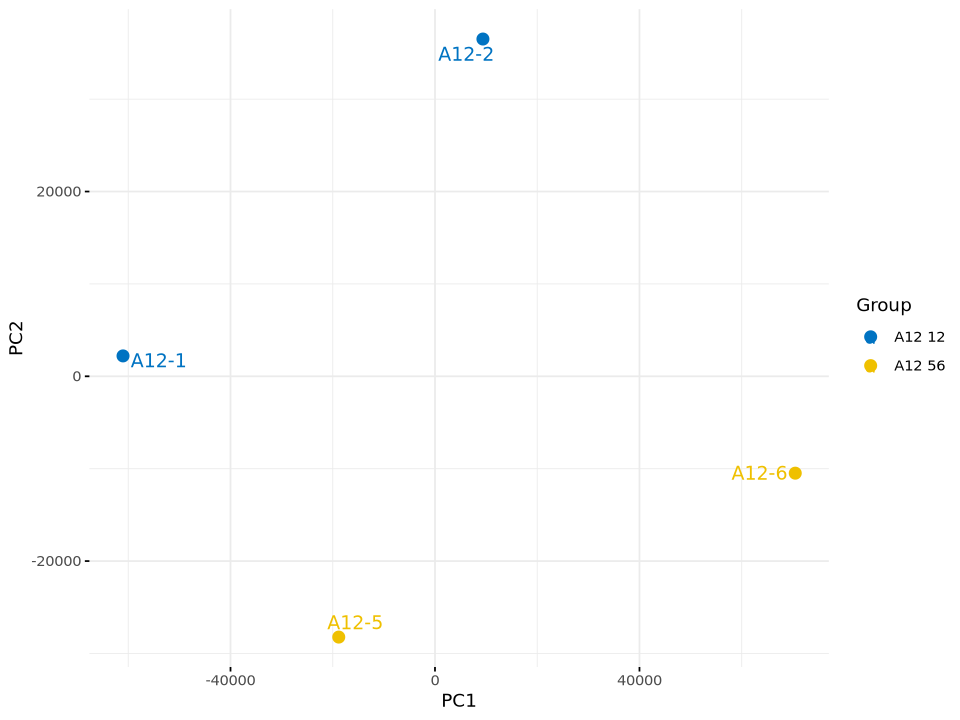

In [46]:
options(repr.plot.width=8, repr.plot.height=6)  
pca_fig=plotPCA(norm,coldata,color="Group")
pca_fig

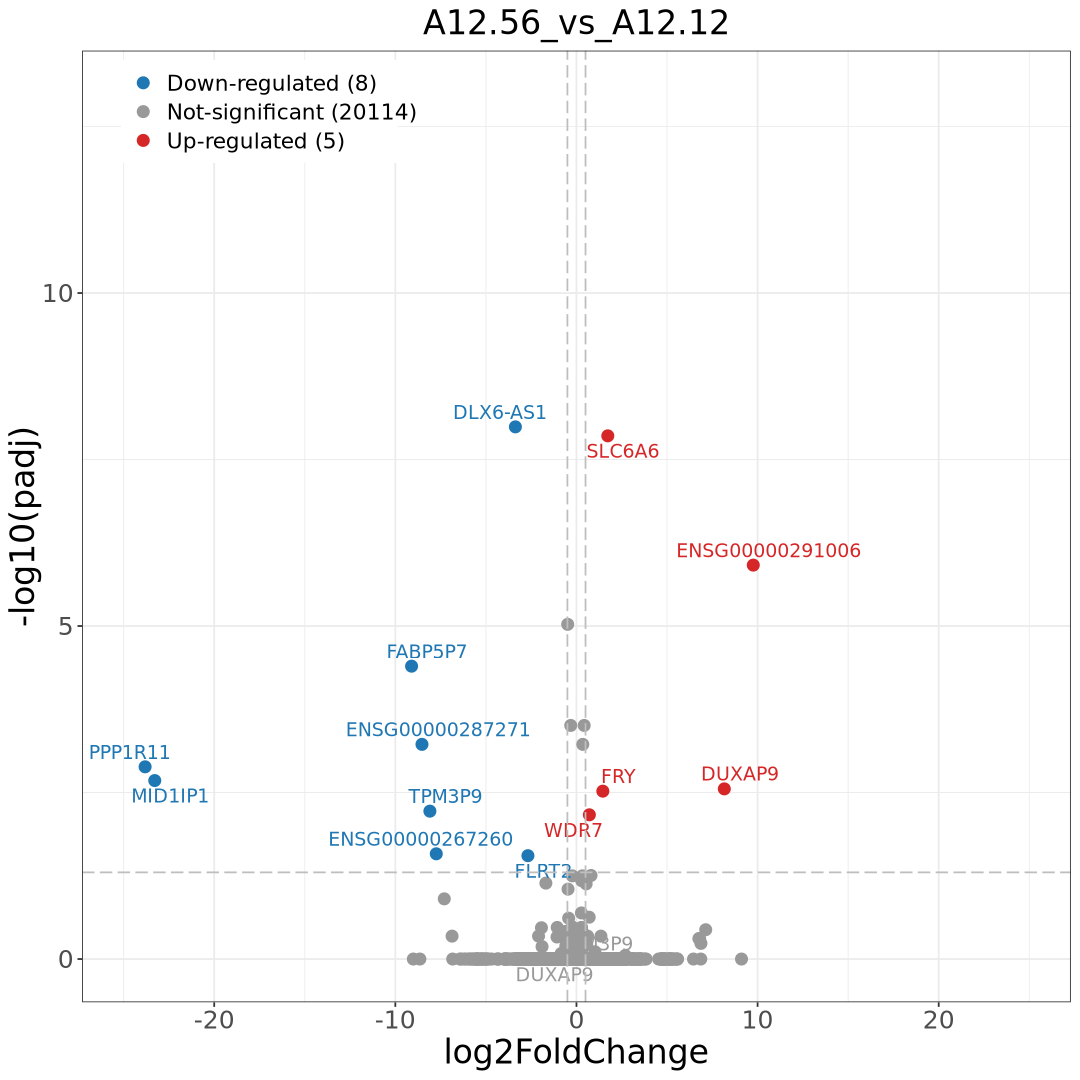

In [47]:
options(repr.plot.width=9, repr.plot.height=9)  

volcano_fig=plot_volcano(res,padj_threshold=0.05,logFC_threshold=0.5)
volcano_fig

In [48]:
get_outname <- function(outdir, Contrast, extension) {
  return(file.path(outdir, paste0(Contrast, "_", extension)))
}

In [49]:
filename=get_outname(outdir,Contrast,"DESeq2.csv")
write.csv(res,filename,quote=F)

filename=get_outname(outdir,Contrast,"pca.pdf")
ggsave(filename,pca_fig,width = 6, height = 6)

filename=get_outname(outdir,Contrast,"volcano.pdf")
ggsave(filename,volcano_fig,width = 8, height = 8)

### A24-1/2_vs_A24-5/6

In [146]:
Contrast="A24 12_vs_A24 56"

coldata=meta|>filter(Group1%in%c("A24")&Group2%in% c("1", "2", "5", "6"))
coldata$Group <- ifelse(coldata$Group2 %in% c("1", "2"), "A24 12", "A24 56")
coldata

,Group1,Group2,Group3,Group
,<chr>,<chr>,<chr>,<chr>
A24-1,A24,1,A24-1,A24 12
A24-2,A24,2,A24-2,A24 12
A24-5,A24,5,A24-5,A24 56
A24-6,A24,6,A24-6,A24 56


In [147]:
dds=salmon_deseq(files,coldata,'A24 12')
norm=as.data.frame(counts(dds, normalized=T))
res=get_DEA_result(dds,padj_threshold=0.05,logFC_threshold=0.5)
table(res$bias)

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]




Down regulated    Not Changed   Up regulated 
           190          18734           1429 

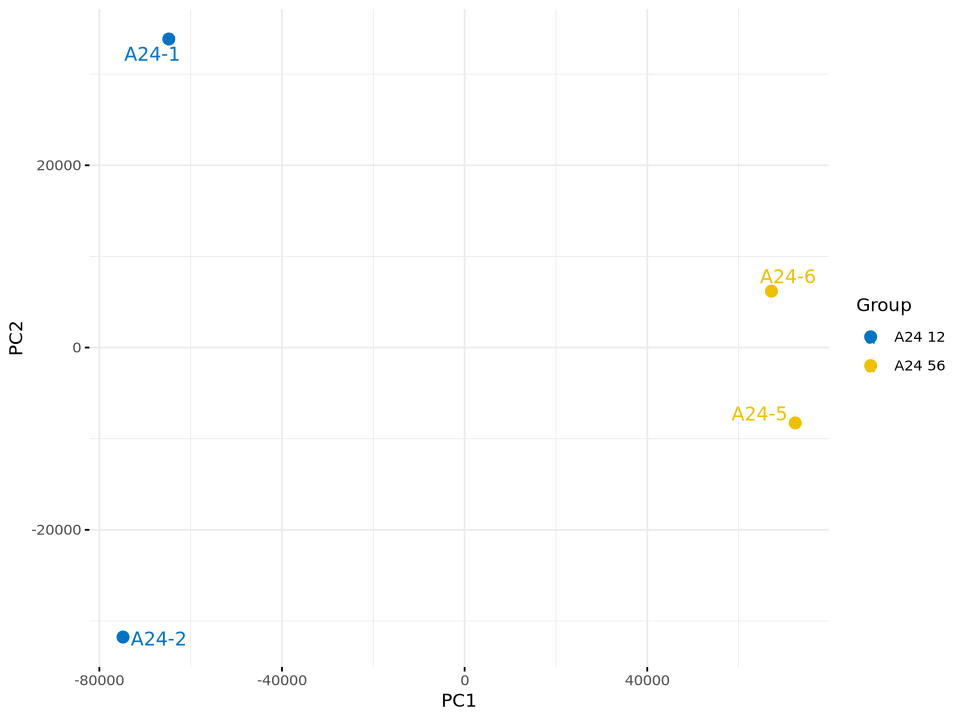

In [148]:
options(repr.plot.width=8, repr.plot.height=6)  
pca_fig=plotPCA(norm,coldata,color="Group")
pca_fig

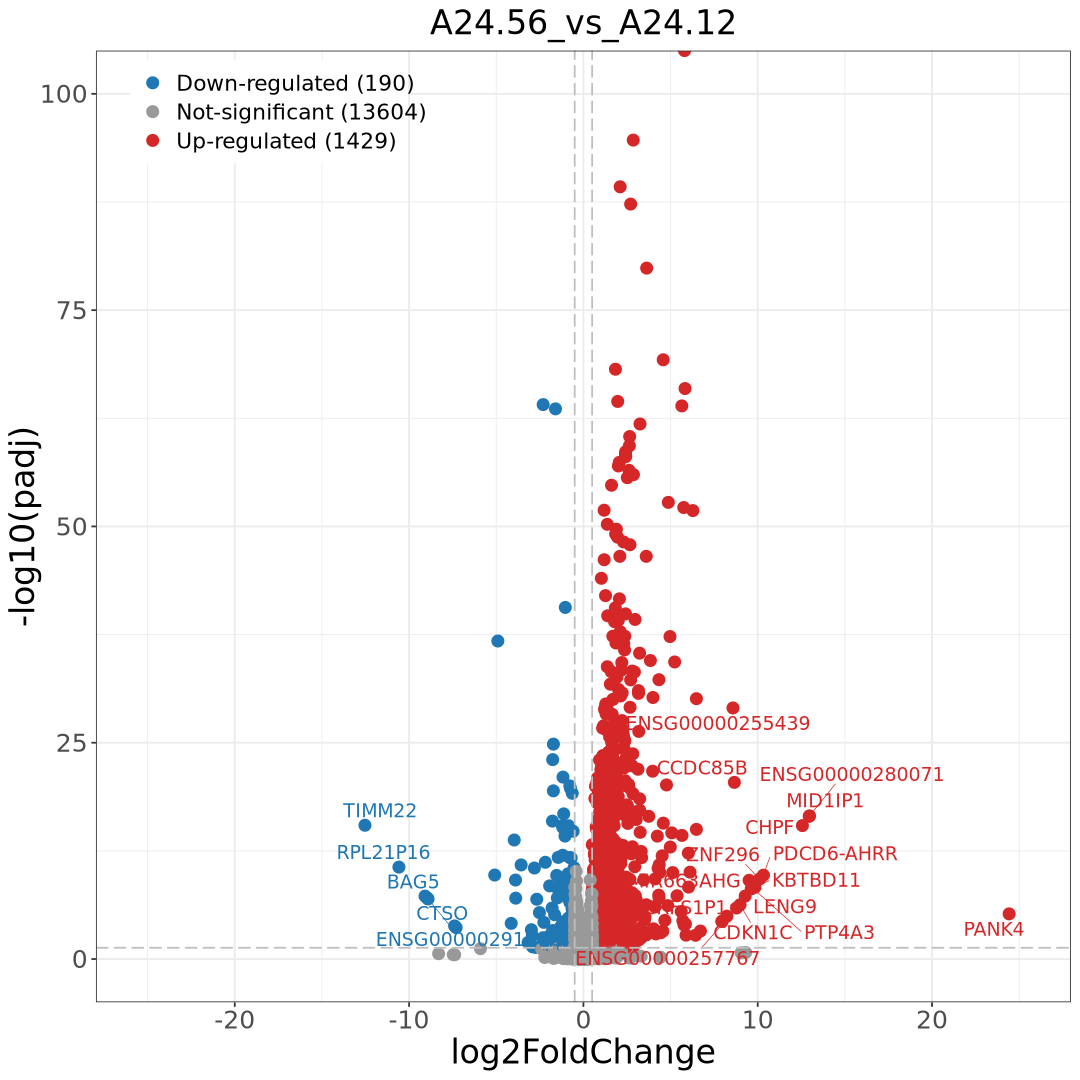

In [149]:
options(repr.plot.width=9, repr.plot.height=9)  

volcano_fig=plot_volcano(res,padj_threshold=0.05,logFC_threshold=0.5)
volcano_fig

In [150]:
get_outname <- function(outdir, Contrast, extension) {
  return(file.path(outdir, paste0(Contrast, "_", extension)))
}

In [151]:
filename=get_outname(outdir,Contrast,"DESeq2.csv")
write.csv(res,filename,quote=F)

filename=get_outname(outdir,Contrast,"pca.pdf")
ggsave(filename,pca_fig,width = 6, height = 6)

filename=get_outname(outdir,Contrast,"volcano.pdf")
ggsave(filename,volcano_fig,width = 8, height = 8)

### D4-1/2_vs_D4-3/4

In [60]:
Contrast="D4 12_vs_D4 34"

coldata=meta|>filter(Group1%in%c("D4")&Group2%in% c("1", "2", "3", "4"))
coldata$Group <- ifelse(coldata$Group2 %in% c("1", "2"), "D4 12", "D4 34")
coldata

,Group1,Group2,Group3,Group
,<chr>,<chr>,<chr>,<chr>
D4-1,D4,1,D4-1,D4 12
D4-2,D4,2,D4-2,D4 12
D4-3,D4,3,D4-3,D4 34
D4-4,D4,4,D4-4,D4 34


In [61]:
dds=salmon_deseq(files,coldata,'D4 12')
norm=as.data.frame(counts(dds, normalized=T))
res=get_DEA_result(dds,padj_threshold=0.05,logFC_threshold=0.5)
table(res$bias)

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]




Down regulated    Not Changed   Up regulated 
            35          22246             22 

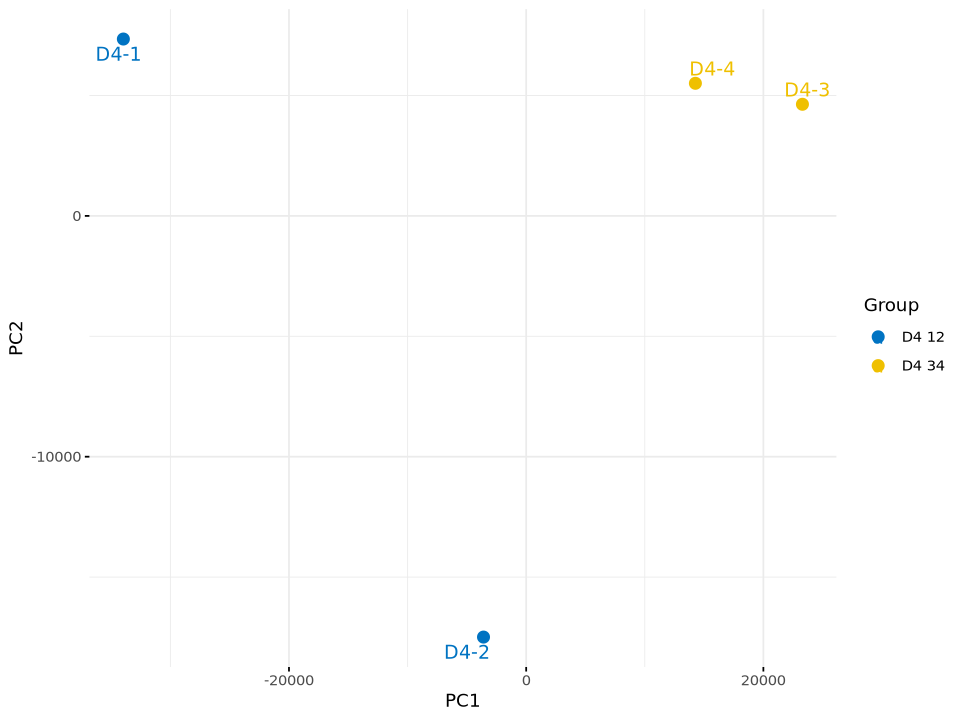

In [62]:
options(repr.plot.width=8, repr.plot.height=6)  
pca_fig=plotPCA(norm,coldata,color="Group")
pca_fig

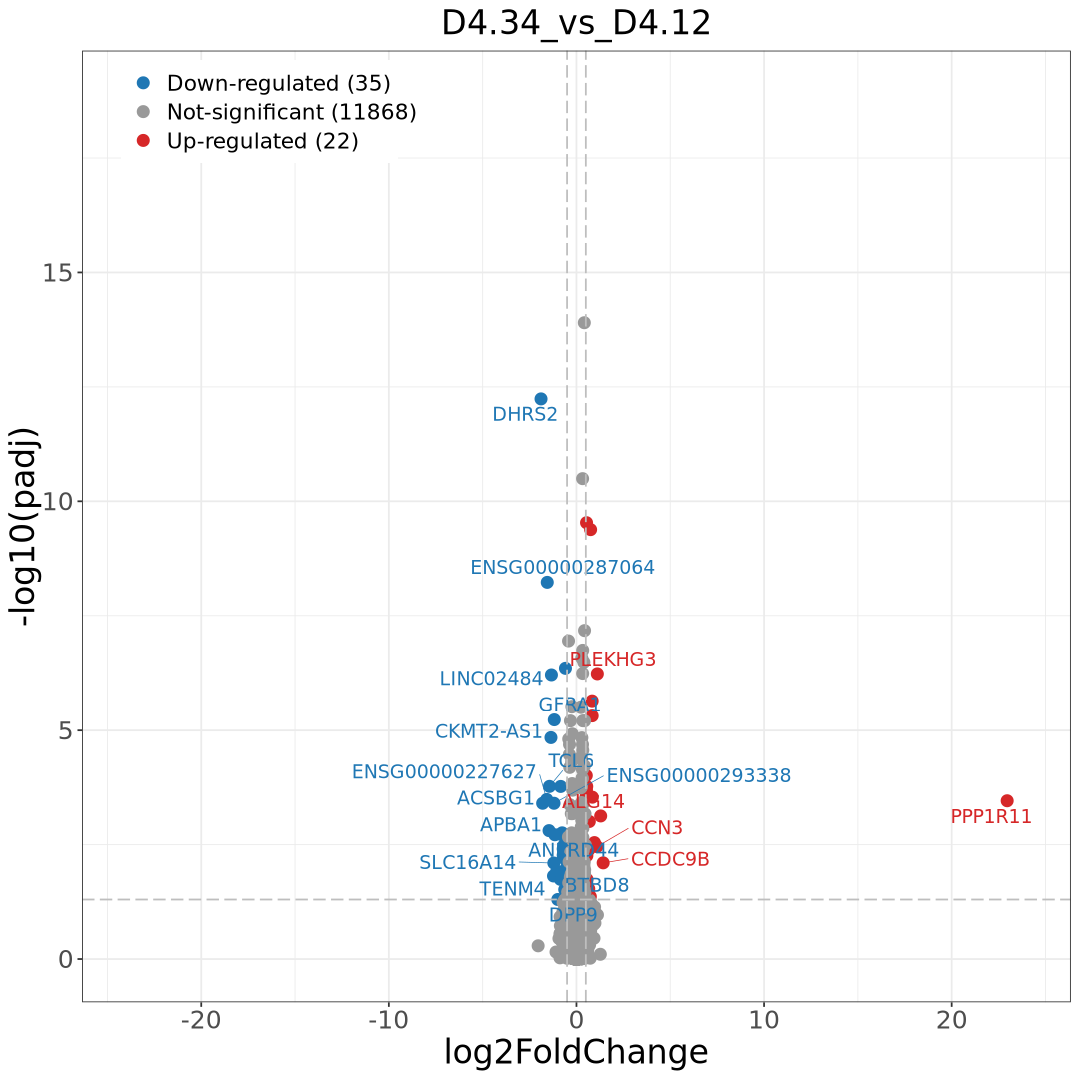

In [63]:
options(repr.plot.width=9, repr.plot.height=9)  

volcano_fig=plot_volcano(res,padj_threshold=0.05,logFC_threshold=0.5)
volcano_fig

In [64]:
get_outname <- function(outdir, Contrast, extension) {
  return(file.path(outdir, paste0(Contrast, "_", extension)))
}

In [65]:
filename=get_outname(outdir,Contrast,"DESeq2.csv")
write.csv(res,filename,quote=F)

filename=get_outname(outdir,Contrast,"pca.pdf")
ggsave(filename,pca_fig,width = 6, height = 6)

filename=get_outname(outdir,Contrast,"volcano.pdf")
ggsave(filename,volcano_fig,width = 8, height = 8)

### L4-1/2_vs_L4-3/4

In [66]:
Contrast="L4 12_vs_L4 34"

coldata=meta|>filter(Group1%in%c("L4")&Group2%in% c("1", "2", "3", "4"))
coldata$Group <- ifelse(coldata$Group2 %in% c("1", "2"), "L4 12", "L4 34")
coldata

,Group1,Group2,Group3,Group
,<chr>,<chr>,<chr>,<chr>
L4-1,L4,1,L4-1,L4 12
L4-2,L4,2,L4-2,L4 12
L4-3,L4,3,L4-3,L4 34
L4-4,L4,4,L4-4,L4 34


In [67]:
dds=salmon_deseq(files,coldata,'L4 12')
norm=as.data.frame(counts(dds, normalized=T))
res=get_DEA_result(dds,padj_threshold=0.05,logFC_threshold=0.5)
table(res$bias)

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]




Down regulated    Not Changed   Up regulated 
            20          22401             18 

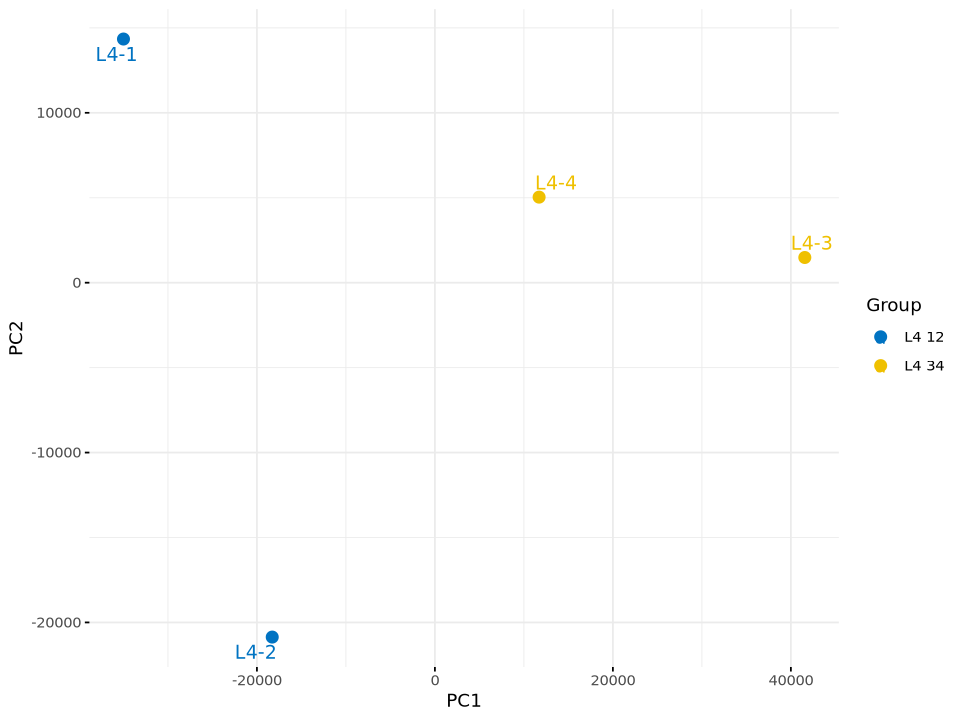

In [68]:
options(repr.plot.width=8, repr.plot.height=6)  
pca_fig=plotPCA(norm,coldata,color="Group")
pca_fig

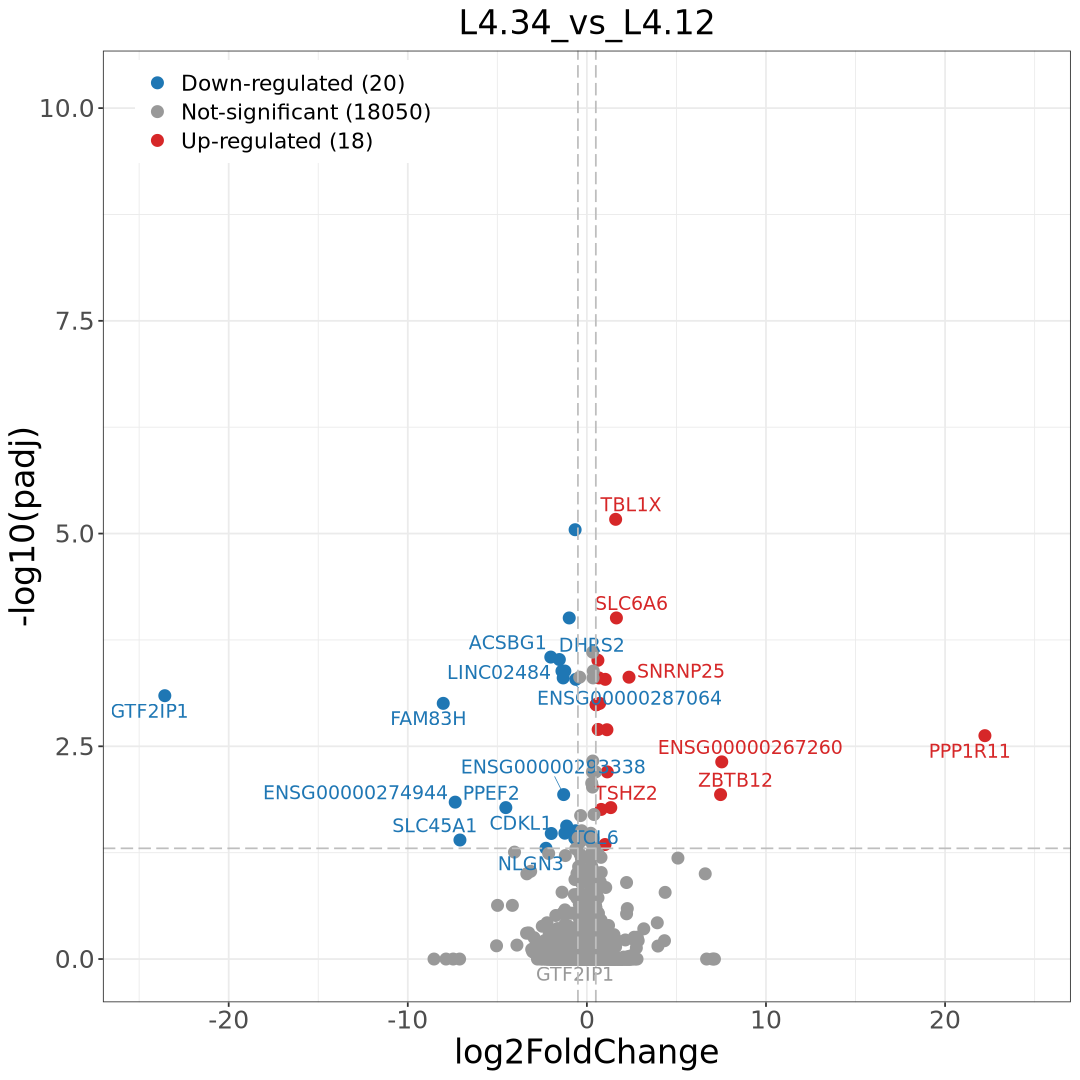

In [69]:
options(repr.plot.width=9, repr.plot.height=9)  

volcano_fig=plot_volcano(res,padj_threshold=0.05,logFC_threshold=0.5)
volcano_fig

In [70]:
get_outname <- function(outdir, Contrast, extension) {
  return(file.path(outdir, paste0(Contrast, "_", extension)))
}

In [71]:
filename=get_outname(outdir,Contrast,"DESeq2.csv")
write.csv(res,filename,quote=F)

filename=get_outname(outdir,Contrast,"pca.pdf")
ggsave(filename,pca_fig,width = 6, height = 6)

filename=get_outname(outdir,Contrast,"volcano.pdf")
ggsave(filename,volcano_fig,width = 8, height = 8)

### D4-1/2_vs_L4-3/4

In [72]:
Contrast="D4 12_vs_L4 34"

coldata=meta|>filter(Group3%in%c("D4-1", "D4-2", "L4-3", "L4-4"))
coldata$Group <- ifelse(coldata$Group2 %in% c("1", "2"), "D4 12", "L4 34")
coldata

,Group1,Group2,Group3,Group
,<chr>,<chr>,<chr>,<chr>
D4-1,D4,1,D4-1,D4 12
D4-2,D4,2,D4-2,D4 12
L4-3,L4,3,L4-3,L4 34
L4-4,L4,4,L4-4,L4 34


In [73]:
dds=salmon_deseq(files,coldata,'D4 12')
norm=as.data.frame(counts(dds, normalized=T))
res=get_DEA_result(dds,padj_threshold=0.05,logFC_threshold=0.5)
table(res$bias)

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]




Down regulated    Not Changed   Up regulated 
            28          22527             28 

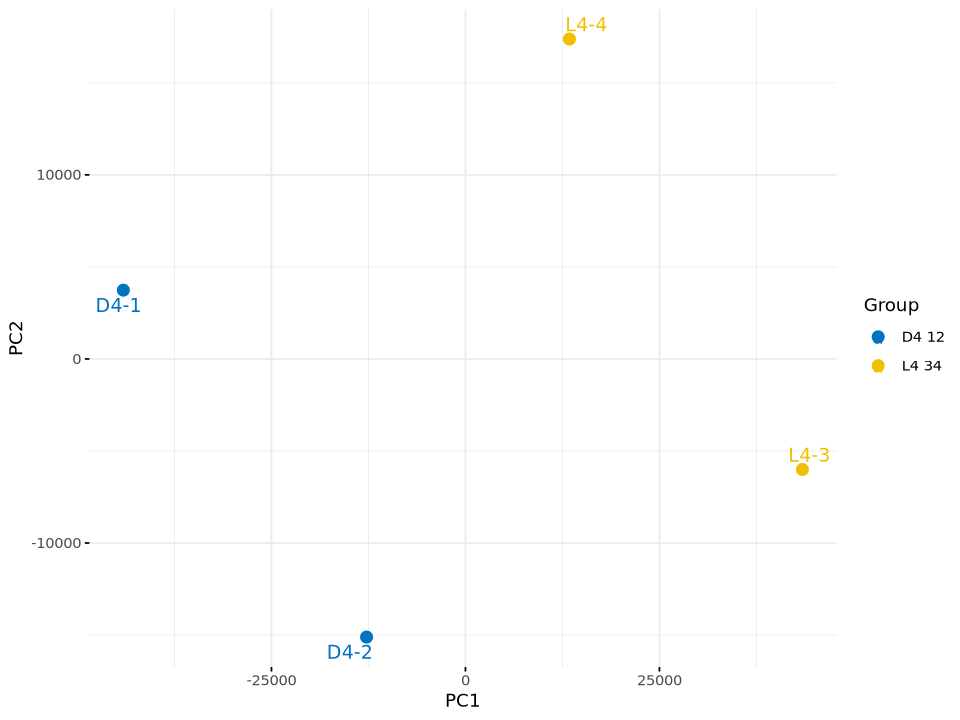

In [74]:
options(repr.plot.width=8, repr.plot.height=6)  
pca_fig=plotPCA(norm,coldata,color="Group")
pca_fig

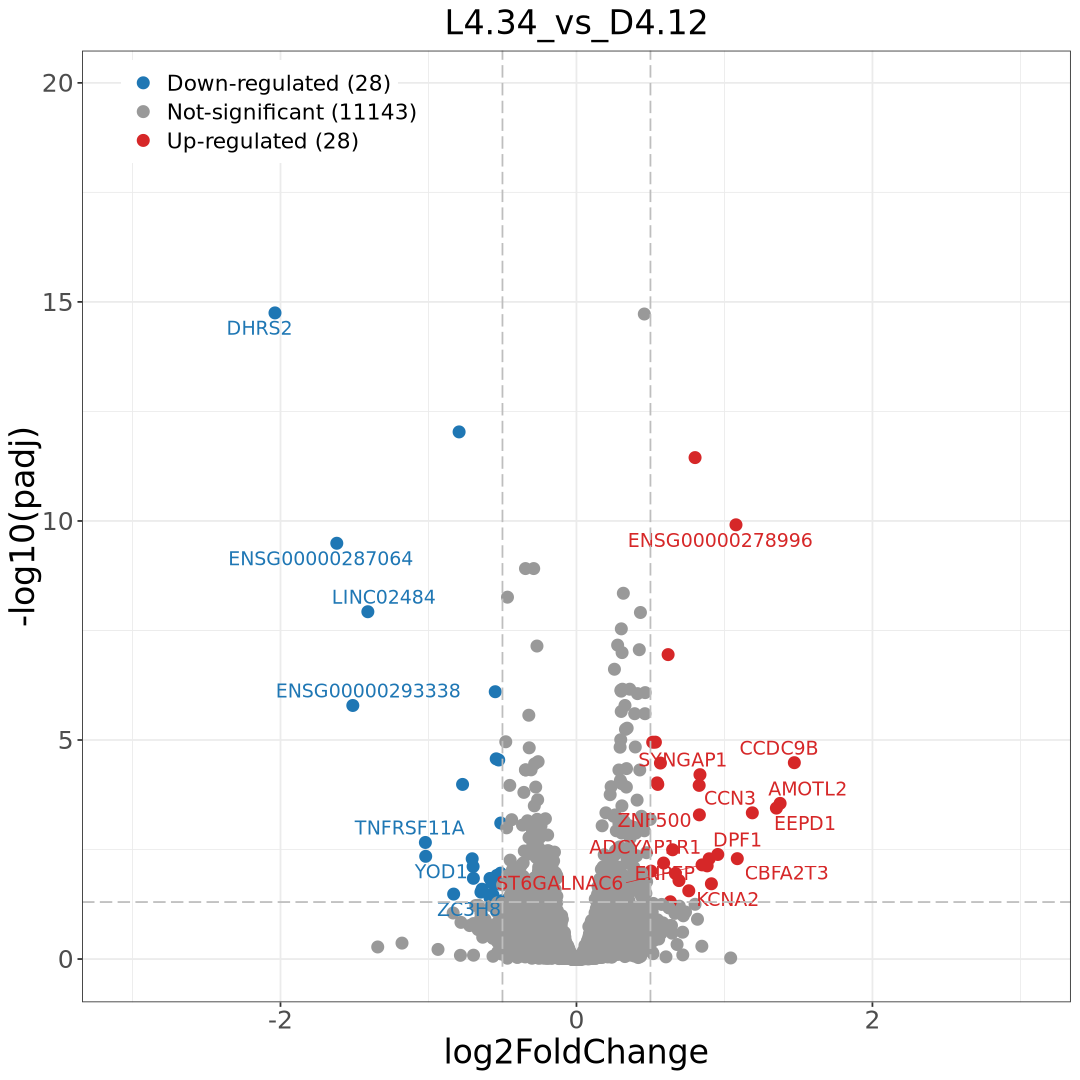

In [75]:
options(repr.plot.width=9, repr.plot.height=9)  

volcano_fig=plot_volcano(res,padj_threshold=0.05,logFC_threshold=0.5)
volcano_fig

In [76]:
get_outname <- function(outdir, Contrast, extension) {
  return(file.path(outdir, paste0(Contrast, "_", extension)))
}

In [77]:
filename=get_outname(outdir,Contrast,"DESeq2.csv")
write.csv(res,filename,quote=F)

filename=get_outname(outdir,Contrast,"pca.pdf")
ggsave(filename,pca_fig,width = 6, height = 6)

filename=get_outname(outdir,Contrast,"volcano.pdf")
ggsave(filename,volcano_fig,width = 8, height = 8)

### D4-3/4_vs_L4-3/4

In [79]:
Contrast="D4 34_vs_L4 34"

coldata=meta|>filter(Group3%in%c("D4-3", "D4-4", "L4-3", "L4-4"))
coldata$Group <- ifelse(coldata$Group1 %in% c("D4"), "D4 34", "L4 34")
coldata

,Group1,Group2,Group3,Group
,<chr>,<chr>,<chr>,<chr>
D4-3,D4,3,D4-3,D4 34
D4-4,D4,4,D4-4,D4 34
L4-3,L4,3,L4-3,L4 34
L4-4,L4,4,L4-4,L4 34


In [80]:
dds=salmon_deseq(files,coldata,'D4 34')
norm=as.data.frame(counts(dds, normalized=T))
res=get_DEA_result(dds,padj_threshold=0.05,logFC_threshold=0.5)
table(res$bias)

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]




Down regulated    Not Changed   Up regulated 
             2          22367             11 

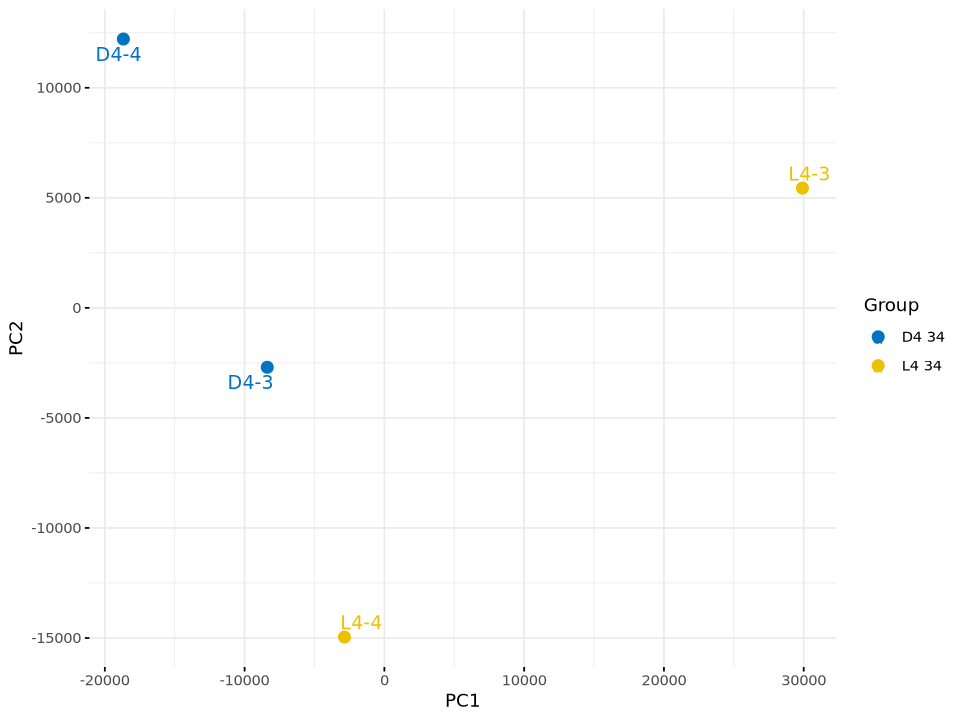

In [81]:
options(repr.plot.width=8, repr.plot.height=6)  
pca_fig=plotPCA(norm,coldata,color="Group")
pca_fig

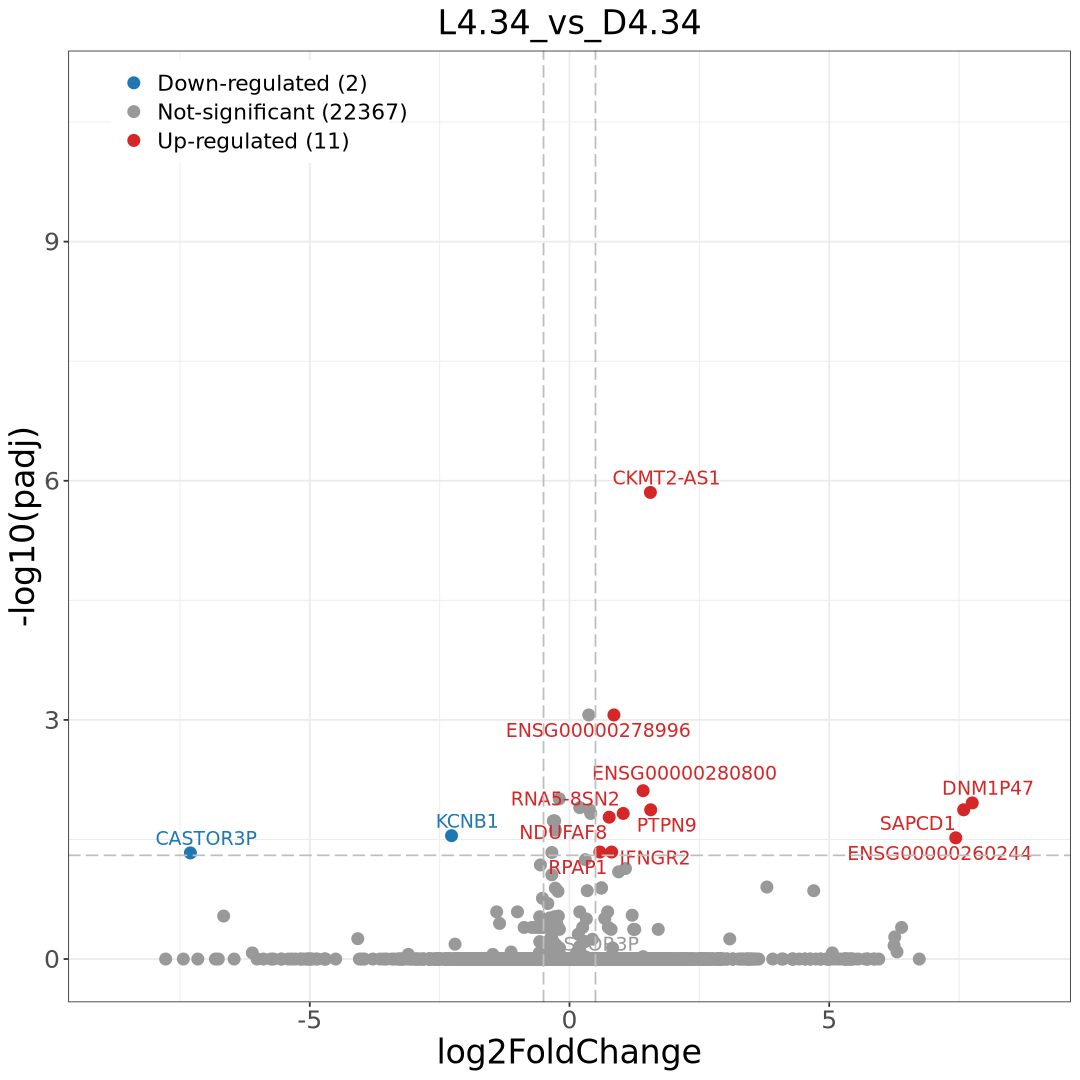

In [82]:
options(repr.plot.width=9, repr.plot.height=9)  

volcano_fig=plot_volcano(res,padj_threshold=0.05,logFC_threshold=0.5)
volcano_fig

In [83]:
get_outname <- function(outdir, Contrast, extension) {
  return(file.path(outdir, paste0(Contrast, "_", extension)))
}

In [84]:
filename=get_outname(outdir,Contrast,"DESeq2.csv")
write.csv(res,filename,quote=F)

filename=get_outname(outdir,Contrast,"pca.pdf")
ggsave(filename,pca_fig,width = 6, height = 6)

filename=get_outname(outdir,Contrast,"volcano.pdf")
ggsave(filename,volcano_fig,width = 8, height = 8)

### D12-1/2_vs_D12-3/4

In [85]:
Contrast="D12 12_vs_D12 34"

coldata=meta|>filter(Group1%in%c("D12")&Group2%in% c("1", "2", "3", "4"))
coldata$Group <- ifelse(coldata$Group2 %in% c("1", "2"), "D12 12", "D12 34")
coldata

,Group1,Group2,Group3,Group
,<chr>,<chr>,<chr>,<chr>
D12-1,D12,1,D12-1,D12 12
D12-2,D12,2,D12-2,D12 12
D12-3,D12,3,D12-3,D12 34
D12-4,D12,4,D12-4,D12 34


In [86]:
dds=salmon_deseq(files,coldata,'D12 12')
norm=as.data.frame(counts(dds, normalized=T))
res=get_DEA_result(dds,padj_threshold=0.05,logFC_threshold=0.5)
table(res$bias)

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]




Down regulated    Not Changed   Up regulated 
            20          23822             12 

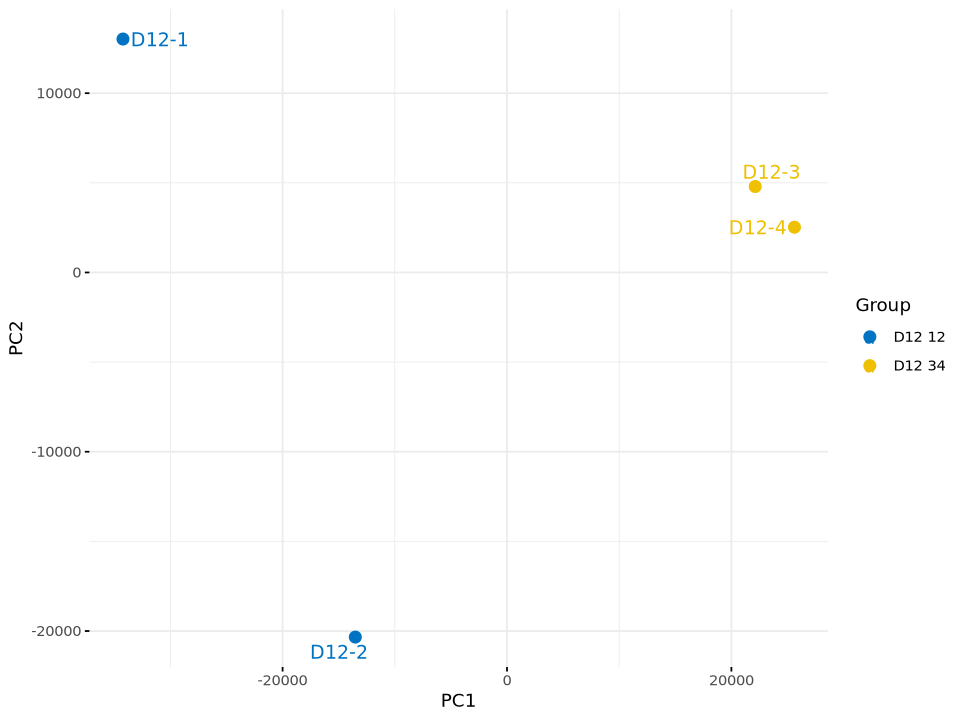

In [87]:
options(repr.plot.width=8, repr.plot.height=6)  
pca_fig=plotPCA(norm,coldata,color="Group")
pca_fig

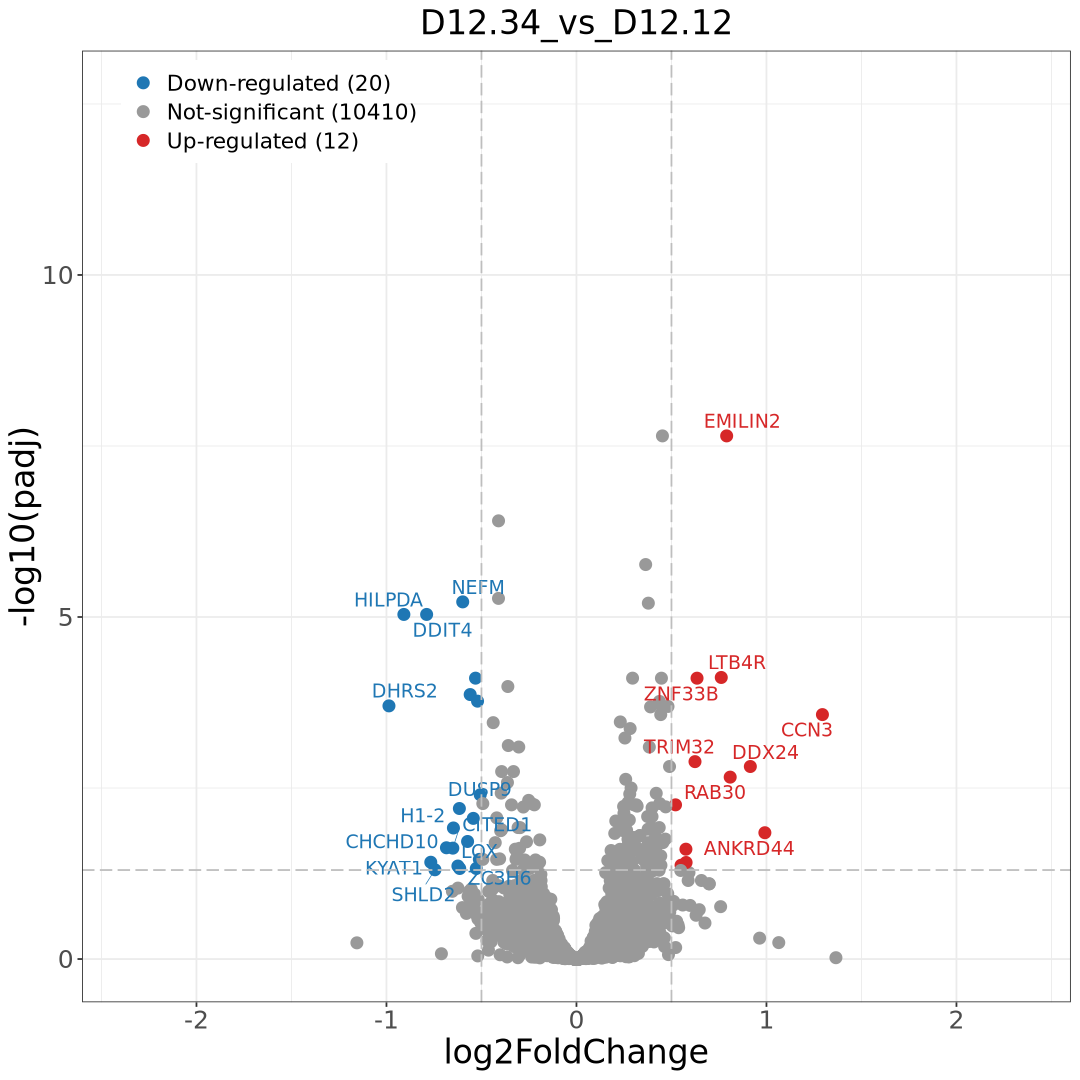

In [88]:
options(repr.plot.width=9, repr.plot.height=9)  

volcano_fig=plot_volcano(res,padj_threshold=0.05,logFC_threshold=0.5)
volcano_fig

In [89]:
get_outname <- function(outdir, Contrast, extension) {
  return(file.path(outdir, paste0(Contrast, "_", extension)))
}

In [90]:
filename=get_outname(outdir,Contrast,"DESeq2.csv")
write.csv(res,filename,quote=F)

filename=get_outname(outdir,Contrast,"pca.pdf")
ggsave(filename,pca_fig,width = 6, height = 6)

filename=get_outname(outdir,Contrast,"volcano.pdf")
ggsave(filename,volcano_fig,width = 8, height = 8)

### L12-1/2_vs_L12-3/4

In [91]:
Contrast="L12 12_vs_L12 34"

coldata=meta|>filter(Group1%in%c("L12")&Group2%in% c("1", "2", "3", "4"))
coldata$Group <- ifelse(coldata$Group2 %in% c("1", "2"), "L12 12", "L12 34")
coldata

,Group1,Group2,Group3,Group
,<chr>,<chr>,<chr>,<chr>
L12-1,L12,1,L12-1,L12 12
L12-2,L12,2,L12-2,L12 12
L12-3,L12,3,L12-3,L12 34
L12-4,L12,4,L12-4,L12 34


In [92]:
dds=salmon_deseq(files,coldata,'L12 12')
norm=as.data.frame(counts(dds, normalized=T))
res=get_DEA_result(dds,padj_threshold=0.05,logFC_threshold=0.5)
table(res$bias)

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]




Down regulated    Not Changed   Up regulated 
            10          23474              9 

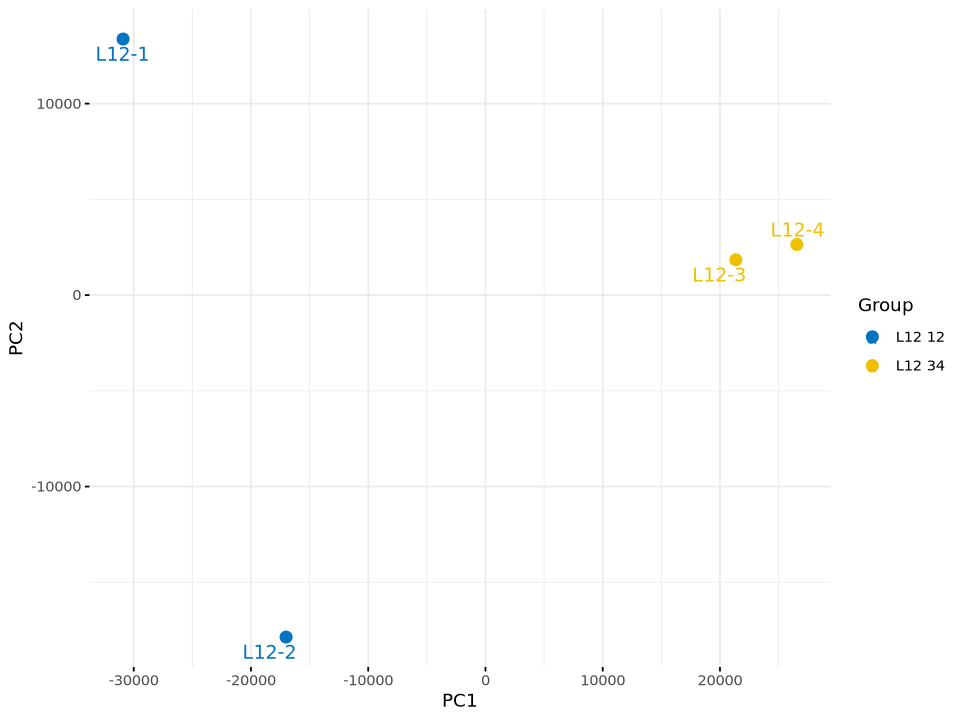

In [93]:
options(repr.plot.width=8, repr.plot.height=6)  
pca_fig=plotPCA(norm,coldata,color="Group")
pca_fig

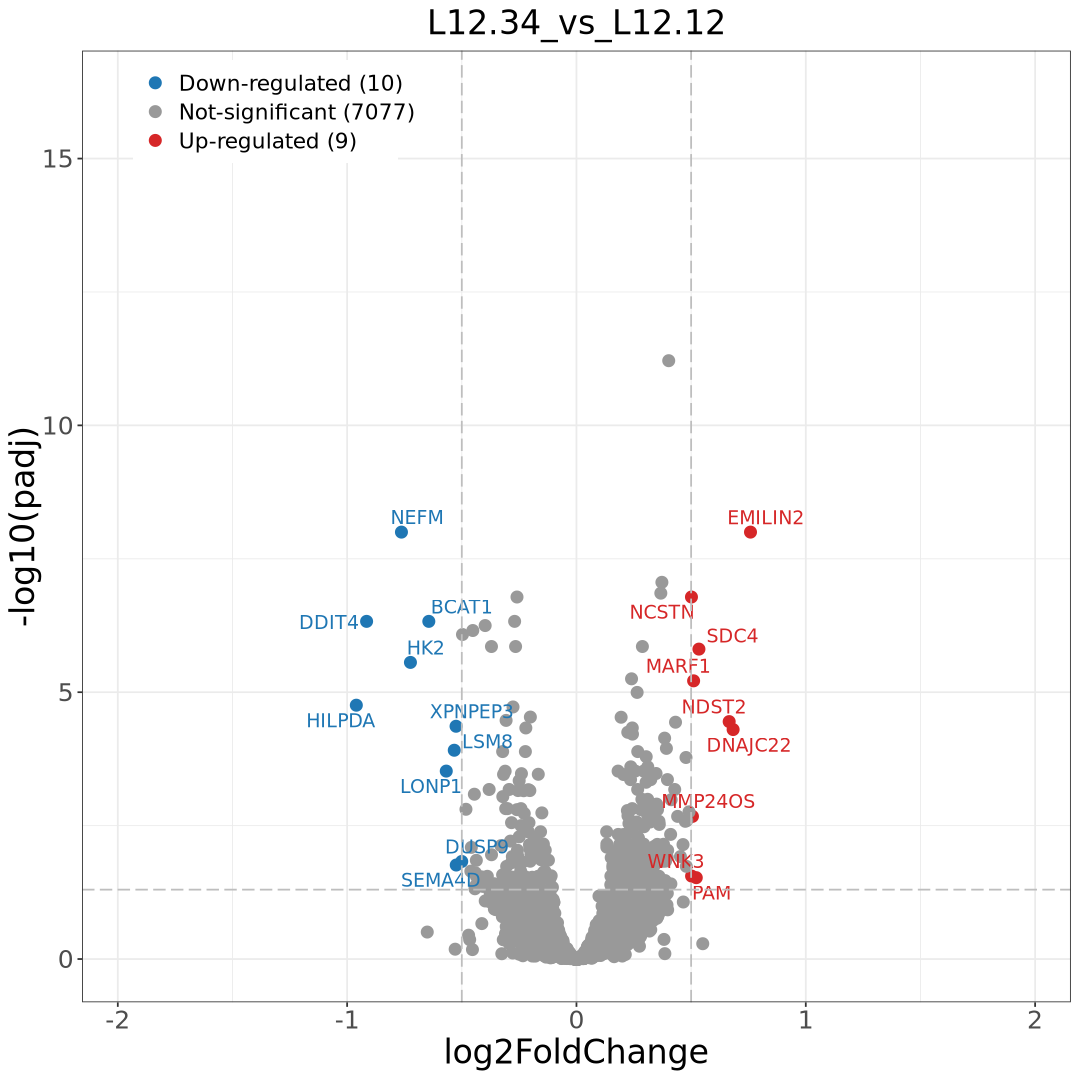

In [94]:
options(repr.plot.width=9, repr.plot.height=9)  

volcano_fig=plot_volcano(res,padj_threshold=0.05,logFC_threshold=0.5)
volcano_fig

In [95]:
get_outname <- function(outdir, Contrast, extension) {
  return(file.path(outdir, paste0(Contrast, "_", extension)))
}

In [96]:
filename=get_outname(outdir,Contrast,"DESeq2.csv")
write.csv(res,filename,quote=F)

filename=get_outname(outdir,Contrast,"pca.pdf")
ggsave(filename,pca_fig,width = 6, height = 6)

filename=get_outname(outdir,Contrast,"volcano.pdf")
ggsave(filename,volcano_fig,width = 8, height = 8)

### D12-1/2_vs_L12-3/4

In [97]:
Contrast="D12 12_vs_L12 34"

coldata=meta|>filter(Group3%in%c("D12-1", "D12-2", "L12-3", "L12-4"))
coldata$Group <- ifelse(coldata$Group1 %in% c("D12"), "D12 12", "L12 34")
coldata

,Group1,Group2,Group3,Group
,<chr>,<chr>,<chr>,<chr>
D12-1,D12,1,D12-1,D12 12
D12-2,D12,2,D12-2,D12 12
L12-3,L12,3,L12-3,L12 34
L12-4,L12,4,L12-4,L12 34


In [101]:
dds=salmon_deseq(files,coldata,'D12 12')
norm=as.data.frame(counts(dds, normalized=T))
res=get_DEA_result(dds,padj_threshold=0.05,logFC_threshold=0.3)
table(res$bias)
#原有差异倍数阈值0.5在火山图中无法直观体现差异情况，故将差异倍数阈值调整至0.3。

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]




Down regulated    Not Changed   Up regulated 
            28          23812             63 

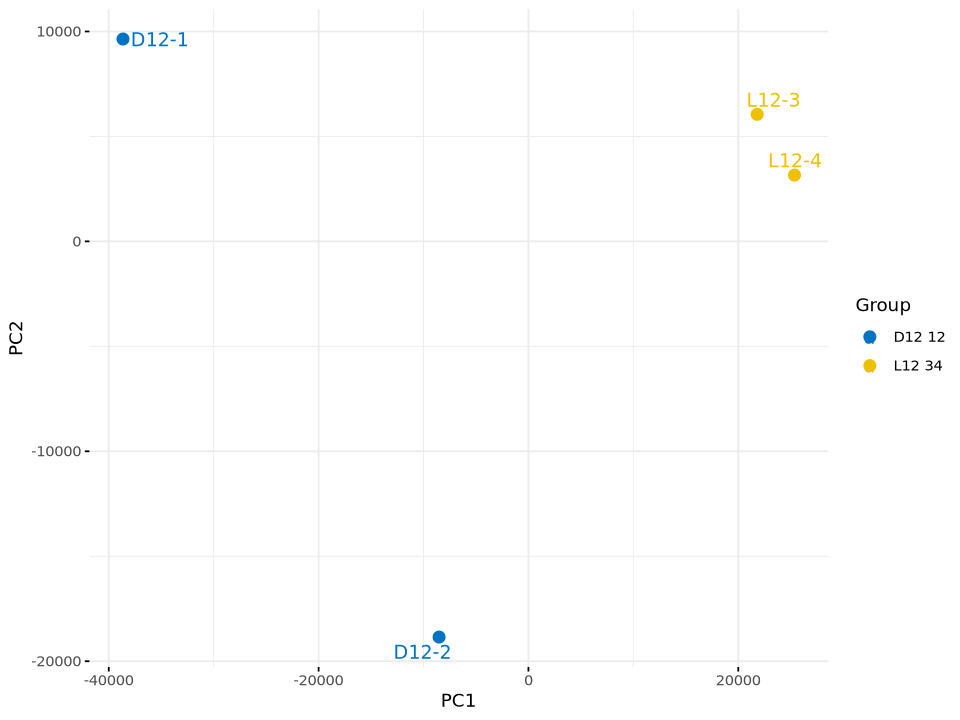

In [102]:
options(repr.plot.width=8, repr.plot.height=6)  
pca_fig=plotPCA(norm,coldata,color="Group")
pca_fig

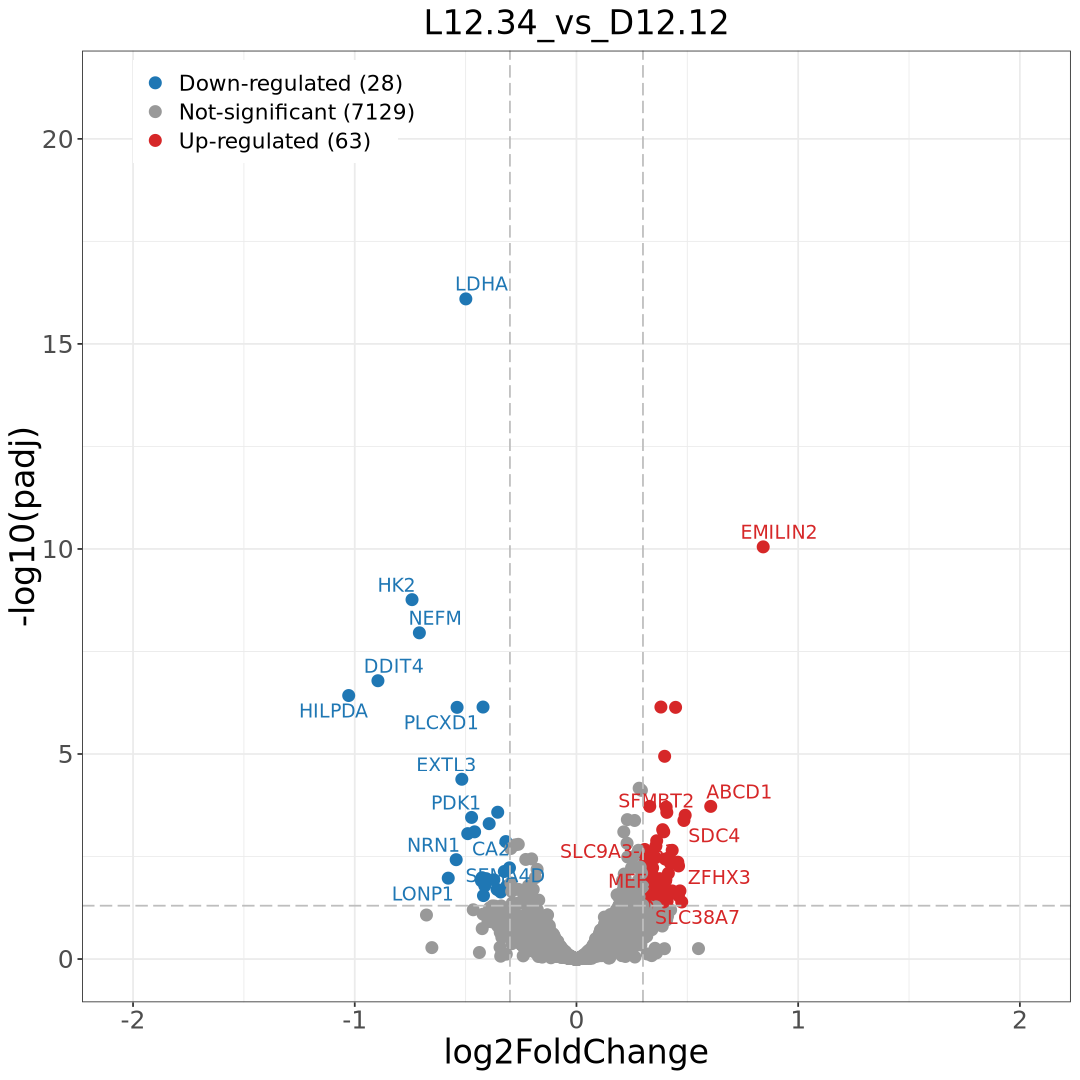

In [103]:
options(repr.plot.width=9, repr.plot.height=9)  

volcano_fig=plot_volcano(res,padj_threshold=0.05,logFC_threshold=0.3)
volcano_fig
#原有差异倍数阈值0.5在火山图中无法直观体现差异情况，故将差异倍数阈值调整至0.3。

In [104]:
get_outname <- function(outdir, Contrast, extension) {
  return(file.path(outdir, paste0(Contrast, "_", extension)))
}

In [105]:
filename=get_outname(outdir,Contrast,"DESeq2.csv")
write.csv(res,filename,quote=F)

filename=get_outname(outdir,Contrast,"pca.pdf")
ggsave(filename,pca_fig,width = 6, height = 6)

filename=get_outname(outdir,Contrast,"volcano.pdf")
ggsave(filename,volcano_fig,width = 8, height = 8)

### D12-3/4_vs_L12-3/4

In [106]:
Contrast="D12 34_vs_L12 34"

coldata=meta|>filter(Group3%in%c("D12-3", "D12-4", "L12-3", "L12-4"))
coldata$Group <- ifelse(coldata$Group1 %in% c("D12"), "D12 34", "L12 34")
coldata

,Group1,Group2,Group3,Group
,<chr>,<chr>,<chr>,<chr>
D12-3,D12,3,D12-3,D12 34
D12-4,D12,4,D12-4,D12 34
L12-3,L12,3,L12-3,L12 34
L12-4,L12,4,L12-4,L12 34


In [107]:
dds=salmon_deseq(files,coldata,'D12 34')
norm=as.data.frame(counts(dds, normalized=T))
res=get_DEA_result(dds,padj_threshold=0.05,logFC_threshold=0.5)
table(res$bias)

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]




Down regulated    Not Changed   Up regulated 
            19          23425              5 

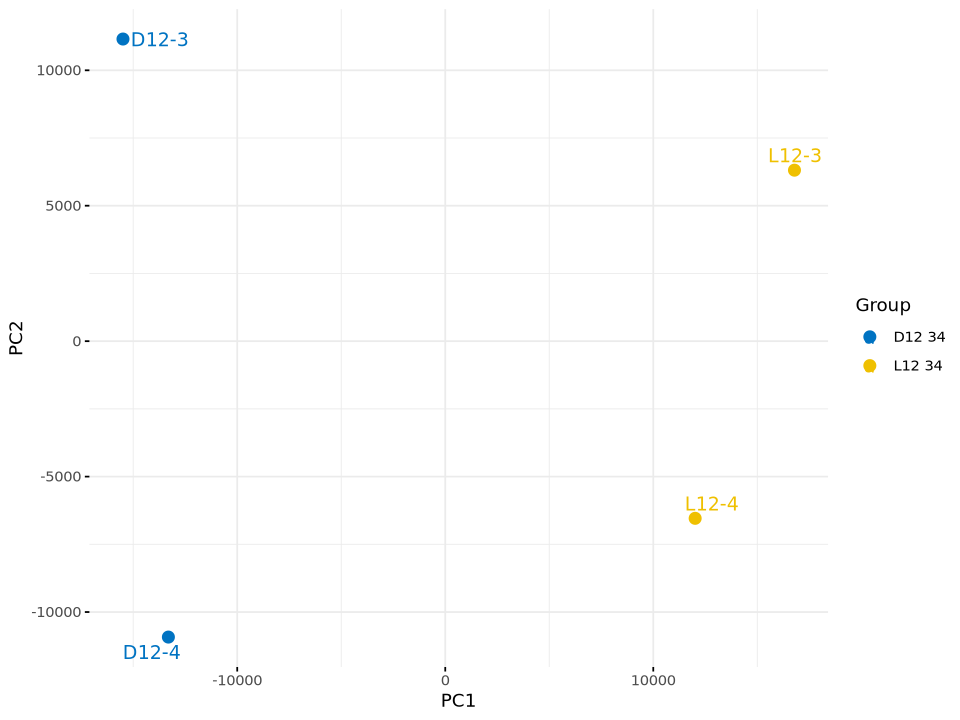

In [108]:
options(repr.plot.width=8, repr.plot.height=6)  
pca_fig=plotPCA(norm,coldata,color="Group")
pca_fig

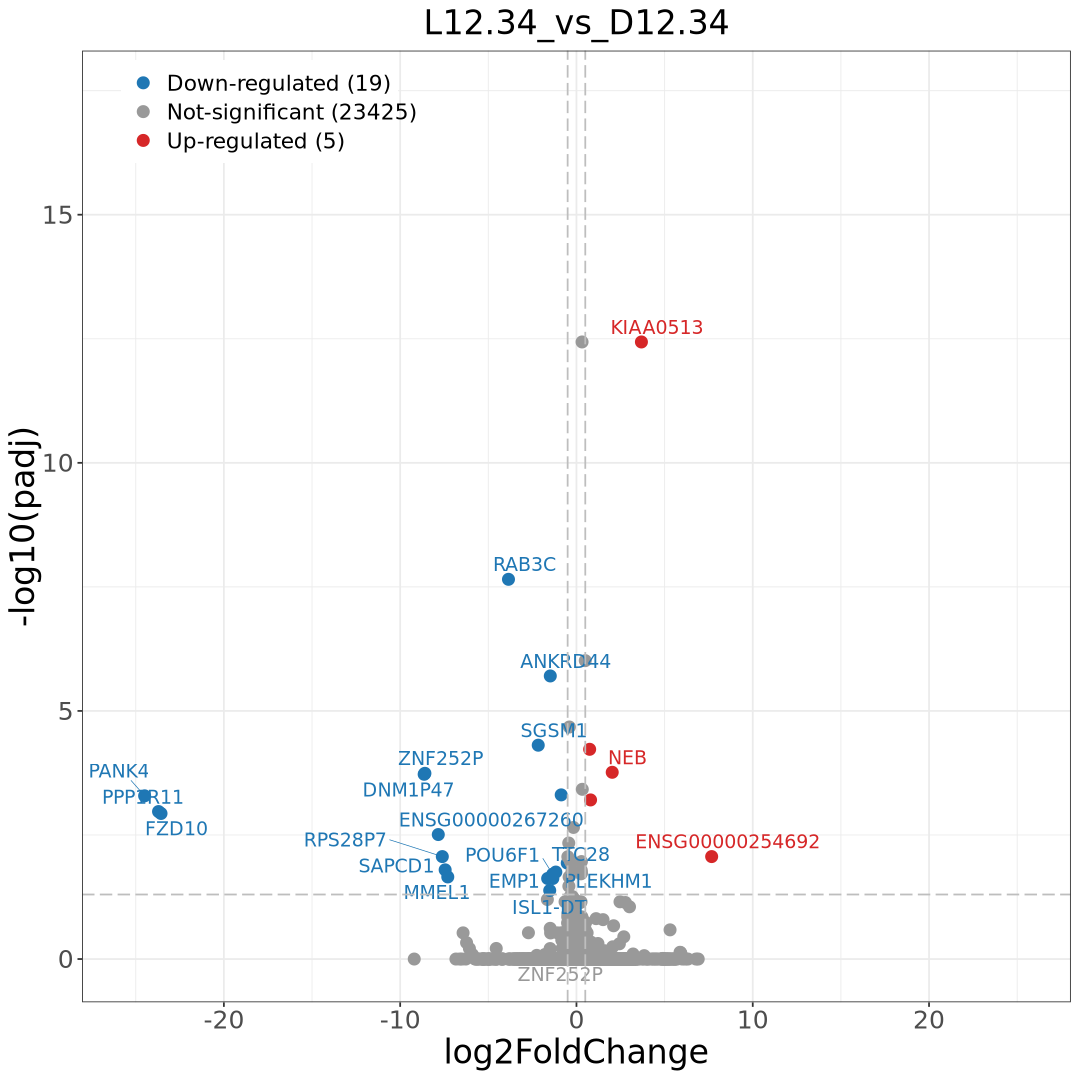

In [109]:
options(repr.plot.width=9, repr.plot.height=9)  

volcano_fig=plot_volcano(res,padj_threshold=0.05,logFC_threshold=0.5)
volcano_fig

In [110]:
get_outname <- function(outdir, Contrast, extension) {
  return(file.path(outdir, paste0(Contrast, "_", extension)))
}

In [111]:
filename=get_outname(outdir,Contrast,"DESeq2.csv")
write.csv(res,filename,quote=F)

filename=get_outname(outdir,Contrast,"pca.pdf")
ggsave(filename,pca_fig,width = 6, height = 6)

filename=get_outname(outdir,Contrast,"volcano.pdf")
ggsave(filename,volcano_fig,width = 8, height = 8)

### L4-3/4_vs_L12-3/4

In [112]:
Contrast="L4 34_vs_L12 34"

coldata=meta|>filter(Group3%in%c("L4-3", "L4-4", "L12-3", "L12-4"))
coldata$Group <- ifelse(coldata$Group1 %in% c("L4"), "L4 34", "L12 34")
coldata

,Group1,Group2,Group3,Group
,<chr>,<chr>,<chr>,<chr>
L12-3,L12,3,L12-3,L12 34
L12-4,L12,4,L12-4,L12 34
L4-3,L4,3,L4-3,L4 34
L4-4,L4,4,L4-4,L4 34


In [113]:
dds=salmon_deseq(files,coldata,'L4 34')
norm=as.data.frame(counts(dds, normalized=T))
res=get_DEA_result(dds,padj_threshold=0.05,logFC_threshold=0.5)
table(res$bias)

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]




Down regulated    Not Changed   Up regulated 
            22          23132             22 

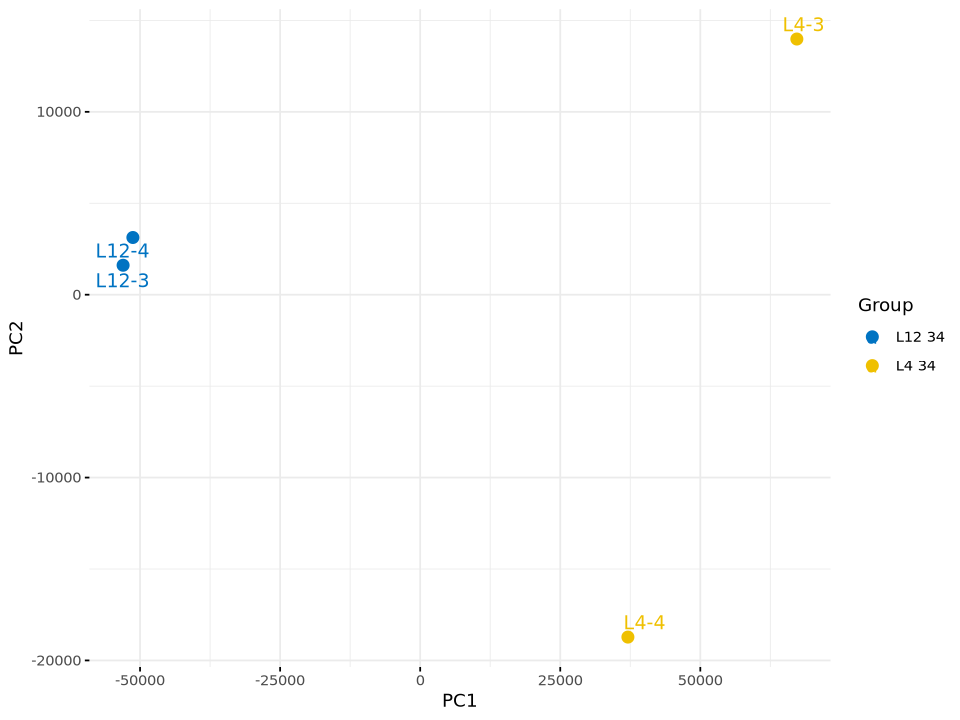

In [114]:
options(repr.plot.width=8, repr.plot.height=6)  
pca_fig=plotPCA(norm,coldata,color="Group")
pca_fig

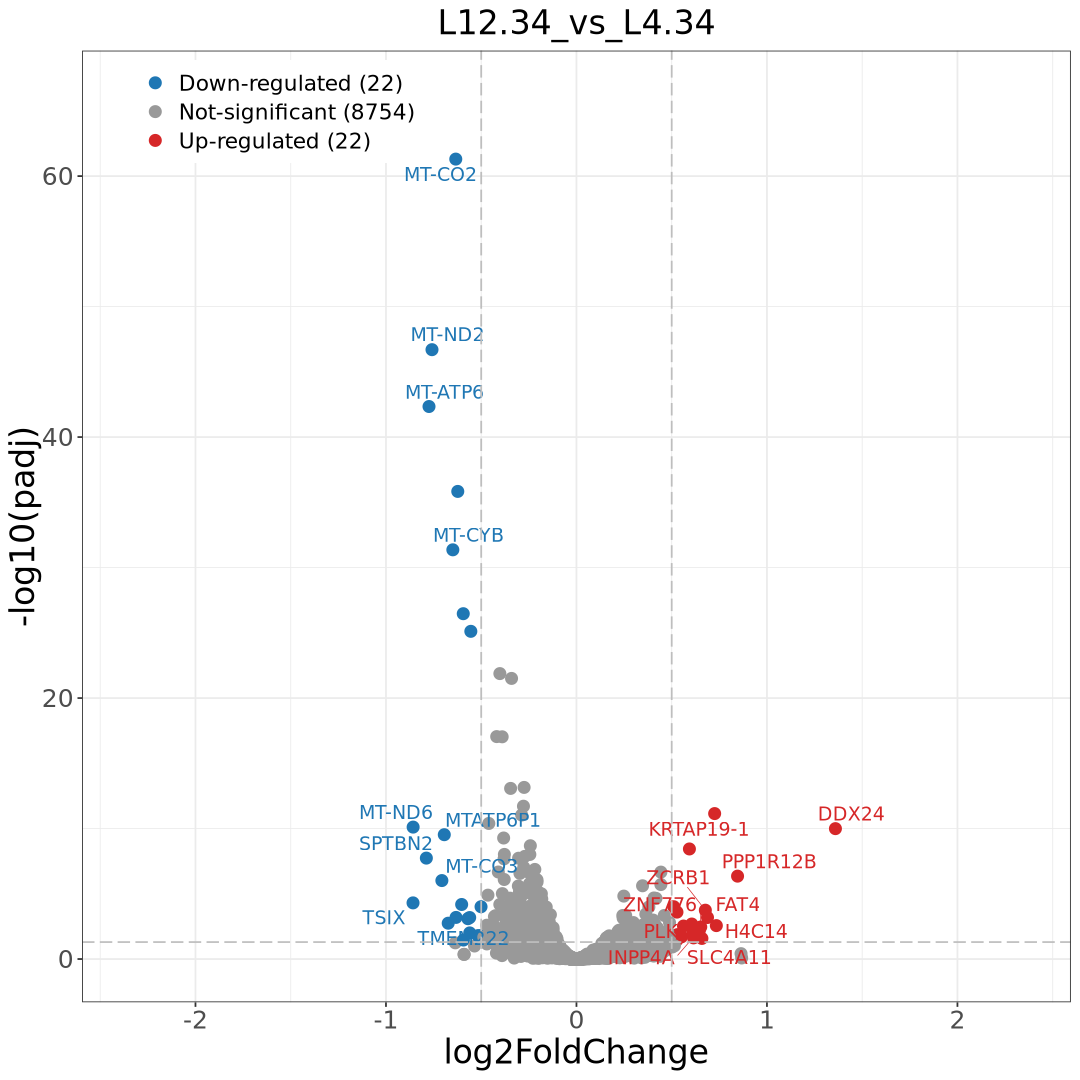

In [115]:
options(repr.plot.width=9, repr.plot.height=9)  

volcano_fig=plot_volcano(res,padj_threshold=0.05,logFC_threshold=0.5)
volcano_fig

In [116]:
get_outname <- function(outdir, Contrast, extension) {
  return(file.path(outdir, paste0(Contrast, "_", extension)))
}

In [117]:
filename=get_outname(outdir,Contrast,"DESeq2.csv")
write.csv(res,filename,quote=F)

filename=get_outname(outdir,Contrast,"pca.pdf")
ggsave(filename,pca_fig,width = 6, height = 6)

filename=get_outname(outdir,Contrast,"volcano.pdf")
ggsave(filename,volcano_fig,width = 8, height = 8)